# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math

# global variable
prev_clip_data = [0, 0, 0, 0]
print('prev_clip_data =', prev_clip_data[0])
bottom_y = 0

# constants
SLOPE_TOLERANCE = 0.25
INTERCEPT_TOLERANCE = 25
TOP_Y_FACTOR = 0.625
BOTTOM_Y_FACTOR = 1.0
MASK_BOTTOM_RIGHT_X_FACTOR = 0.975
MASK_BOTTOM_LEFT_X_FACTOR = 0.125
MASK_TOP_RIGHT_X_FACTOR = 0.575
MASK_TOP_LEFT_X_FACTOR = 0.425

prev_clip_data = 0


## Read in an Image

In [2]:
#reading in an image
#image = mpimg.imread('test_images/Challenge6.jpg')

#printing out some stats and plotting
#print('This image is:', type(image), 'with dimensions:', image.shape)
#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray',
#    for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    """
    NOTE: this section iterates through the line co-ordinates returned by Hough transform and
    calculates the average slope (m) and intercept (b) for left lane and right lane seperately.  Any
    outliers are filtered.

    The left and right lanes are extrapolated by determining top and bottom x values using y = mx + b
    for y = 330 and 539

    """

    global prev_clip_data
    global bottom_y
#    global SLOPE_TOLERANCE
#    global INTERCEPT_TOLERANCE

    prev_left_slope = prev_clip_data[0]
    prev_left_intercept = prev_clip_data[1]
    prev_right_slope = prev_clip_data[2]
    prev_right_intercept = prev_clip_data[3]

    left_lane_slope_accumulator = 0.0
    left_lane_intercept_accumulator = 0.0
    left_lane_line_counter = 0
    left_lane_slope_average = 0.0
    left_lane_intercept_average = 0.0
    right_lane_slope_accumulator = 0.0
    right_lane_intercept_accumulator = 0.0
    right_lane_line_counter = 0
    right_lane_slope_average = 0.0
    right_lane_intercept_average = 0.0

    top_y = int(img.shape[0] * TOP_Y_FACTOR)
#    bottom_y = int(img.shape [0] * BOTTOM_Y_FACTOR)



    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1,x2],[y1,y2], 1)         # calculate slope & intercept
            print ('slope, intercept =', slope, ' ', intercept)
            print ('line =', line)
            if(((slope*slope) > 0.1) & ((slope*slope) < 100)):       # filter outliers
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """

    if prev_left_slope == 0:
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)   # calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):       # filter outliers
                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=2)
                    if y1 > bottom_y:
                        bottom_y = y1
                    if y2 > bottom_y:
                        bottom_y = y2
#                    if x1 < (img.shape[1]/2):
                    if slope < 0:
                        left_lane_slope_accumulator += slope
                        left_lane_intercept_accumulator += intercept
                        left_lane_line_counter += 1
                    else:
                        right_lane_slope_accumulator += slope
                        right_lane_intercept_accumulator += intercept
                        right_lane_line_counter += 1
                else:
#                    print ('ignoring line ', line, ' as outlier ', slope, intercept)
                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)

        if left_lane_line_counter != 0:                                    # handle division by zero scenario
            left_lane_slope_average = left_lane_slope_accumulator/left_lane_line_counter
            left_lane_intercept_average = left_lane_intercept_accumulator/left_lane_line_counter
            left_lane_top_x = (top_y-left_lane_intercept_average)/left_lane_slope_average
            left_lane_bottom_x = (bottom_y-left_lane_intercept_average)/left_lane_slope_average
            cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        if right_lane_line_counter != 0:                                    # handle division by zero scenario
            right_lane_slope_average = right_lane_slope_accumulator/right_lane_line_counter
            right_lane_intercept_average = right_lane_intercept_accumulator/right_lane_line_counter
            right_lane_top_x = (top_y-right_lane_intercept_average)/right_lane_slope_average
            right_lane_bottom_x = (bottom_y-right_lane_intercept_average)/right_lane_slope_average
            cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)

        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average, 
                             right_lane_slope_average, right_lane_intercept_average]
        print('current clip data =', prev_clip_data)

    else:
        left_lane_slope_accumulator = prev_left_slope
        left_lane_intercept_accumulator = prev_left_intercept
        left_lane_line_counter = 1
        right_lane_slope_accumulator = prev_right_slope
        right_lane_intercept_accumulator = prev_right_intercept
        right_lane_line_counter = 1
        
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)# calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):       # filter outliers
                    if slope < 0:
                        if x1 < (img.shape[1]/2):
#                            if True:
                            if ((prev_left_slope-SLOPE_TOLERANCE) < slope < (prev_left_slope+SLOPE_TOLERANCE)) & \
                              ((prev_left_intercept-INTERCEPT_TOLERANCE) < intercept < \
                                 (prev_left_intercept+INTERCEPT_TOLERANCE)):
    #                            left_line_x1 = (y1-prev_left_intercept)/prev_left_slope
    #                            left_line_x2 = (y2-prev_left_intercept)/prev_left_slope
    #                           if((int(left_line_x1)-x1)< 100 & (int(left_line_x2)-x2)<100):
                                left_lane_slope_accumulator += slope
                                left_lane_intercept_accumulator += intercept
                                left_lane_line_counter += 1
                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=2)
#                                print('green data left =', slope, intercept)
                                if y1 > bottom_y:
                                    bottom_y = y1
                                if y2 > bottom_y:
                                    bottom_y = y2
                            else:
    #                           print('ignoring line ', line, ' as outlier ', slope, intercept)
                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                        else:
#                           print('ignoring line ', line, ' as outlier ', slope, intercept)
                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                    else:
                        if x1 > (img.shape[1]/2):
#                            if True:
                            if ((prev_right_slope-SLOPE_TOLERANCE) < slope < (prev_right_slope+SLOPE_TOLERANCE)) & \
                                  ((prev_right_intercept-INTERCEPT_TOLERANCE) < \
                                     intercept < (prev_right_intercept+INTERCEPT_TOLERANCE)):
    #                            right_line_x1 = (y1-prev_right_intercept)/prev_right_slope
    #                            right_line_x2 = (y2-prev_right_intercept)/prev_right_slope
    #                            print('line x1 x2 =', right_line_x1, right_line_x1)
    #                            if((int(right_line_x1)-x1)< 100 & (int(right_line_x2)-x2)<100):
                                right_lane_slope_accumulator += slope
                                right_lane_intercept_accumulator += intercept
                                right_lane_line_counter += 1
                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=2)
#                                print('green data right =', slope, intercept)
                                if y1 > bottom_y:
                                    bottom_y = y1
                                if y2 > bottom_y:
                                    bottom_y = y2
                            else:
    #                            print('ignoring line ', line, ' as outlier ', slope, intercept)
                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                        else:
    #                    print('ignoring line ', line, ' as outlier ', slope, intercept)
                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                else:
#                    print('ignoring line ', line, ' as outlier ', slope, intercept)
                    cv2.line(img, (x1, y1), (x2, y2), color=[252, 255, 111], thickness=2)

        
        left_lane_slope_average = left_lane_slope_accumulator/left_lane_line_counter
        left_lane_intercept_average = left_lane_intercept_accumulator/left_lane_line_counter
        left_lane_top_x = (top_y-left_lane_intercept_average)/left_lane_slope_average
        left_lane_bottom_x = (bottom_y-left_lane_intercept_average)/left_lane_slope_average
        cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        right_lane_slope_average = right_lane_slope_accumulator/right_lane_line_counter
        right_lane_intercept_average = right_lane_intercept_accumulator/right_lane_line_counter
        right_lane_top_x = (top_y-right_lane_intercept_average)/right_lane_slope_average
        right_lane_bottom_x = (bottom_y-right_lane_intercept_average)/right_lane_slope_average
        cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)
        
        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average,  
                             right_lane_slope_average, right_lane_intercept_average]

        print('current clip data =', prev_clip_data)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#    print ('line =', lines[0])
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['Challenge5.jpg',
 'Challenge6.jpg',
 'Challenge7.jpg',
 'Output2_Challenge5-old.jpg',
 'Output2_Challenge5-old1.jpg',
 'Output2_Challenge5.jpg',
 'Output2_Challenge6-old.jpg',
 'Output2_Challenge6-old1.jpg',
 'Output2_Challenge6.jpg',
 'Output2_Challenge7-old.jpg',
 'Output2_Challenge7-old1.jpg',
 'Output2_Challenge7.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

processing image  Challenge5.jpg
current clip data = [-0.83573912382499926, 1433.1443942747658, 0.55971572764127109, 82.520299773534447]
output image name = Output2_Challenge5.jpg
processing image  Challenge6.jpg
current clip data = [-0.81355932203389725, 1365.983050847457, 0.67650378316937509, -34.75307320595325]
output image name = Output2_Challenge6.jpg
processing image  Challenge7.jpg
current clip data = [-0.56538767947200663, 1198.3334786507276, 0.62166659141893577, 27.845235994443808]
output image name = Output2_Challenge7.jpg
ignoring image  Output2_Challenge5-old.jpg
ignoring image  Output2_Challenge5-old1.jpg
ignoring image  Output2_Challenge5.jpg
ignoring image  Output2_Challenge6-old.jpg
ignoring image  Output2_Challenge6-old1.jpg
ignoring image  Output2_Challenge6.jpg
ignoring image  Output2_Challenge7-old.jpg
ignoring image  Output2_Challenge7-old1.jpg
ignoring image  Output2_Challenge7.jpg
dummy statement to make the above multiline comment work


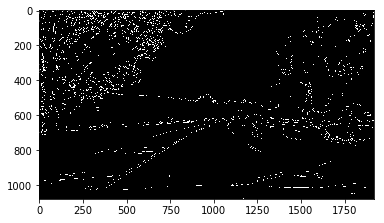

In [5]:
# Pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def pipeline(input_image):
#    print("inside pipeline")
#    print("input image")
#    plt.imshow(inImg)
    
    gaussian_kernel_size = 7  # kernel size used for gaussian blur
    canny_low_threshold = 40 # pixel with gradient below the low threshold are rejected
    canny_high_threshold = 120 # gradient used to detect strong edges
    
    center_x = input_image.shape[1]/2
    mask_bottom_right_x = input_image.shape[1] * MASK_BOTTOM_RIGHT_X_FACTOR
    mask_bottom_left_x = input_image.shape[1] * MASK_BOTTOM_LEFT_X_FACTOR
    mask_top_right_x = input_image.shape[1] * MASK_TOP_RIGHT_X_FACTOR
    mask_top_left_x = input_image.shape[1] * MASK_TOP_LEFT_X_FACTOR
    mask_top_y = input_image.shape[0] * TOP_Y_FACTOR
    mask_bottom_y = input_image.shape[0] * BOTTOM_Y_FACTOR

    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments
    
    grayscale_image = grayscale(input_image)
#    print ("gray image")
#    plt.imshow(grayscale_image, cmap='gray')

    gaussian_blurred_image = gaussian_blur(grayscale_image, gaussian_kernel_size)
#    print ("gaussian image")
#    plt.imshow(gaussian_blurred_image, cmap='gray')

    canny_image = canny(gaussian_blurred_image, canny_low_threshold, canny_high_threshold)
#    print ("canny image")
    plt.imshow(canny_image, cmap='gray')
    plt.imsave('canny.png', canny_image, format='png', cmap='gray')

    masked_image = region_of_interest(canny_image, vertices)
#    print ("masked image")
#    plt.imshow(masked_image, cmap='gray')
#    plt.show()

    hough_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
#    print ("hough image")
#    plt.imshow(hough_image, cmap='gray')
#    plt.show()

    weighted_image = weighted_img(hough_image, input_image)
#    print ("weighted image")
#    plt.imshow(weighted_image)
    
    return weighted_image

'''
NOTE : This section is used to test the pipeline against the set of test images provided
'''

images = os.listdir('test_images/')

for image in images:
    
    if image[:6] != 'Output':
        input_image = mpimg.imread('test_images/%s' % image)
        print('processing image ', image)
        prev_clip_data = [0, 0, 0, 0]
        bottom_y = 0
        output_image = pipeline(input_image)
        output_img_name = 'Output2_' + image
        print('output image name =', output_img_name)
        mpimg.imsave('test_images/%s' % output_img_name, output_image)
    else:
        print('ignoring image ', image)

print('dummy statement to make the above multiline comment work')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = pipeline(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

current clip data = [-0.64755553182738801, 847.071890243388, 0.60042114134009261, 25.609435434399138]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|                                                                                                                                                                                                             | 0/251 [00:00<?, ?it/s]

green data left = -0.673003802281 856.942965779
green data right = 0.577380952381 43.9226190476
green data right = 0.605095541401 27.5477707006
green data left = -0.666666666667 862.333333333
green data left = -0.666666666667 853.666666667
green data right = 0.578431372549 38.637254902
green data left = -0.64880952381 845.470238095
current clip data = [-0.6605404382503236, 853.09701882361912, 0.59033225191783423, 33.929270021154352]


  0%|▊                                                                                                                                                                                                    | 1/251 [00:00<02:11,  1.91it/s]

green data left = -0.673306772908 856.693227092
green data right = 0.592592592593 26.8888888889
green data left = -0.68 868.2
green data left = -0.627218934911 834.485207101
green data left = -0.65625 849.96875
current clip data = [-0.65946322921398748, 852.48884060316925, 0.59146242225521428, 30.409079455020628]


  1%|█▌                                                                                                                                                                                                   | 2/251 [00:00<02:04,  2.00it/s]

green data left = -0.670995670996 855.432900433
green data left = -0.675496688742 857.927152318
green data left = -0.675977653631 867.61452514
green data left = -0.625 832.5
green data right = 0.576271186441 44.7118644068
green data right = 0.614035087719 17.5263157895
green data left = -0.617647058824 829.617647059
green data right = 0.615384615385 9.15384615384
green data right = 0.575 43.8
current clip data = [-0.65409671690103166, 849.26351092540597, 0.59443066235995945, 29.120221161025977]


  1%|██▎                                                                                                                                                                                                  | 3/251 [00:01<02:02,  2.03it/s]

green data left = -0.672811059908 857.239631336
green data left = -0.666666666667 856.333333333
green data left = -0.674157303371 872.415730337
green data left = -0.648888888889 846.982222222
green data right = 0.6 27.8
green data left = -0.666666666667 856.0
current clip data = [-0.663881217066978, 856.37240469240714, 0.5972153311799786, 28.460110580513721]


  2%|███▏                                                                                                                                                                                                 | 4/251 [00:01<01:50,  2.23it/s]

green data left = -0.649193548387 848.358870968
green data left = -0.696 880.208
green data left = -0.714285714286 870.714285714
green data right = 0.597826086957 25.1847826087
green data left = -0.738095238095 878.404761905
green data left = -0.666666666667 863.666666667
green data left = -0.652173913043 849.043478261
green data left = -0.642857142857 846.857142857
current clip data = [-0.67789418005028856, 861.70320138298428, 0.59752070906824994, 26.822446594604752]


  2%|███▉                                                                                                                                                                                                 | 5/251 [00:02<01:44,  2.35it/s]

green data left = -0.701492537313 883.119402985
green data left = -0.672413793103 859.827586207
green data left = -0.65 848.7
green data left = -0.69512195122 871.719512195
green data left = -0.669230769231 857.661538462
green data left = -0.690909090909 880.963636364
green data left = -0.642857142857 846.928571429
green data left = -0.631578947368 842.842105263
current clip data = [-0.67016649022801156, 861.49617269855344, 0.59752070906824994, 26.822446594604752]


  2%|████▋                                                                                                                                                                                                | 6/251 [00:02<01:40,  2.43it/s]

green data left = -0.672955974843 860.641509434
green data left = -0.702830188679 884.603773585
green data left = -0.638888888889 848.25
green data left = -0.642857142857 847.714285714
green data left = -0.692307692308 878.538461538
green data left = -0.672413793103 862.0
green data left = -0.673913043478 867.739130435
green data right = 0.603305785124 22.173553719
green data left = -0.651376146789 850.293577982
green data left = -0.702380952381 885.69047619
current clip data = [-0.67200903135553924, 864.69673875770718, 0.60041324709610844, 24.498000156806512]


  3%|█████▍                                                                                                                                                                                               | 7/251 [00:02<01:41,  2.41it/s]

green data left = -0.67619047619 863.514285714
green data left = -0.673913043478 861.043478261
green data left = -0.671641791045 860.970149254
green data right = 0.621118012422 4.41614906832
current clip data = [-0.6734385855172631, 862.55616299664848, 0.61076562975923454, 14.457074612564652]


  3%|██████▎                                                                                                                                                                                              | 8/251 [00:03<01:35,  2.53it/s]

green data left = -0.700421940928 874.113924051
green data right = 0.597765363128 23.0335195531
green data right = 0.647435897436 -10.4551282051
green data left = -0.688888888889 870.377777778
green data left = -0.695652173913 870.434782609
green data left = -0.707317073171 880.0
green data right = 0.625668449198 0.893048128343
green data left = -0.69512195122 871.195121951
current clip data = [-0.6934734356062856, 871.44629489749593, 0.62040883488037135, 6.9821285222125615]


  4%|███████                                                                                                                                                                                              | 9/251 [00:03<01:33,  2.58it/s]

green data left = -0.697674418605 874.162790698
green data right = 0.605633802817 17.1267605634
green data right = 0.640449438202 -4.25842696629
green data right = 0.617021276596 7.06382978723
green data left = -0.690476190476 870.738095238
green data left = -0.666666666667 860.666666667
green data right = 0.595744680851 29.3617021277
green data right = 0.604938271605 19.012345679
current clip data = [-0.68707267783844772, 869.25346187498269, 0.61403271749187882, 12.548056618866882]


  4%|███████▊                                                                                                                                                                                            | 10/251 [00:04<01:29,  2.68it/s]

green data left = -0.698689956332 875.043668122
green data right = 0.622950819672 11.393442623
green data right = 0.6 22.8
green data right = 0.607843137255 16.5490196078
green data right = 0.603053435115 20.7404580153
green data left = -0.674418604651 869.139534884
green data left = -0.652631578947 851.715789474
green data right = 0.628571428571 5.22857142857
green data left = -0.700336700337 877.393939394
current clip data = [-0.68262990362111087, 868.50927874971944, 0.61274192301747521, 14.87659138224881]


  4%|████████▌                                                                                                                                                                                           | 11/251 [00:04<01:33,  2.58it/s]

green data left = -0.68085106383 867.276595745
green data right = 0.601063829787 20.4414893617
green data right = 0.622222222222 10.8444444444
green data left = -0.698305084746 874.938983051
green data right = 0.602739726027 17.4109589041
green data left = -0.698181818182 874.207272727
green data right = 0.634615384615 -2.88461538461
green data right = 0.576086956522 39.3369565217
current clip data = [-0.68999196759461978, 871.23303256813017, 0.60824500703190809, 16.67097087160548]


  5%|█████████▎                                                                                                                                                                                          | 12/251 [00:04<01:31,  2.61it/s]

green data right = 0.619718309859 13.0
green data left = -0.698630136986 875.02739726
green data right = 0.597402597403 23.2337662338
green data right = 0.627906976744 5.23255813954
green data right = 0.634615384615 -3.67307692308
green data right = 0.58064516129 37.4838709677
green data right = 0.613636363636 5.20454545455
green data left = -0.689655172414 873.344827586
green data left = -0.679389312977 866.541984733
current clip data = [-0.68941664749295184, 871.53681053685841, 0.61173854293998731, 13.878947820588916]


  5%|██████████▏                                                                                                                                                                                         | 13/251 [00:05<01:27,  2.73it/s]

green data left = -0.698245614035 873.526315789
green data left = -0.692307692308 872.384615385
green data right = 0.619047619048 11.1428571429
green data left = -0.697749196141 874.485530547
green data right = 0.586206896552 33.0689655172
green data left = -0.704081632653 883.714285714
green data right = 0.608695652174 20.3913043478
current clip data = [-0.69636015652605521, 875.12951159437182, 0.60642217767831008, 19.620518707129001]


  6%|██████████▉                                                                                                                                                                                         | 14/251 [00:05<01:32,  2.56it/s]

green data left = -0.697674418605 873.069767442
green data right = 0.623188405797 3.31884057971
green data right = 0.591836734694 36.6326530612
green data left = -0.683333333333 869.633333333
green data right = 0.615384615385 15.8461538462
green data right = 0.590909090909 39.0
green data left = -0.698412698413 874.761904762
green data right = 0.584905660377 34.8301886792
current clip data = [-0.69394515171918436, 873.14862928286743, 0.60210778080672656, 24.874725812243071]


  6%|███████████▋                                                                                                                                                                                        | 15/251 [00:06<01:43,  2.27it/s]

green data left = -0.698412698413 874.26984127
green data left = -0.701149425287 876.114942529
green data right = 0.625 1.375
current clip data = [-0.69783575847307977, 874.51113769381482, 0.61355389040336528, 13.124862906119883]


  6%|████████████▍                                                                                                                                                                                       | 16/251 [00:06<01:45,  2.24it/s]

green data left = -0.72192513369 883.294117647
green data left = -0.67816091954 868.459770115
green data left = -0.728 895.08
green data left = -0.720779220779 883.616883117
green data left = -0.722222222222 894.055555556
current clip data = [-0.71148720911743135, 883.16957735470896, 0.61355389040336528, 13.124862906119883]


  7%|█████████████▎                                                                                                                                                                                      | 17/251 [00:07<01:47,  2.18it/s]

green data left = -0.723214285714 884.732142857
green data left = -0.751655629139 907.993377483
green data left = -0.746268656716 906.731343284
green data left = -0.7 873.2
green data left = -0.741935483871 889.709677419
green data left = -0.739130434783 903.826086957
green data right = 0.621621621622 11.6756756757
green data left = -0.7 873.8
current clip data = [-0.72671146241759821, 890.39527566934453, 0.61758775601249305, 12.400269290898056]


  7%|██████████████                                                                                                                                                                                      | 18/251 [00:07<01:49,  2.12it/s]

green data left = -0.754098360656 908.655737705
green data left = -0.722772277228 883.485148515
green data left = -0.740740740741 905.851851852
green data right = 0.632653061224 -3.18367346939
green data left = -0.75355450237 909.236966825
green data left = -0.736842105263 901.947368421
green data left = -0.740740740741 893.148148148
green data right = 0.618320610687 8.48091603053
green data left = -0.736842105263 905.526315789
current clip data = [-0.73903778683481502, 899.78085161553531, 0.62285380930800316, 5.8991706173470151]


  8%|██████████████▊                                                                                                                                                                                     | 19/251 [00:08<01:55,  2.02it/s]

green data left = -0.753333333333 910.0
green data left = -0.700729927007 875.299270073
green data left = -0.74358974359 905.358974359
green data left = -0.727272727273 897.545454545
green data right = 0.6 30.6
green data left = -0.7 883.7
green data left = -0.705882352941 878.529411765
current clip data = [-0.72426369585415762, 892.88770890823798, 0.6114269046540004, 18.249585308674551]


  8%|███████████████▌                                                                                                                                                                                    | 20/251 [00:08<02:02,  1.88it/s]

green data left = -0.697452229299 874.00955414
green data left = -0.753333333333 909.493333333
green data left = -0.75 908.75
green data left = -0.723926380368 883.803680982
green data left = -0.759493670886 912.367088608
current clip data = [-0.7347448849568381, 896.88522766181461, 0.6114269046540004, 18.249585308674551]


  8%|████████████████▍                                                                                                                                                                                   | 21/251 [00:09<01:56,  1.97it/s]

green data left = -0.700440528634 873.449339207
green data left = -0.753333333333 909.0
green data right = 0.62 13.2
green data left = -0.754266211604 907.771331058
green data left = -0.698360655738 872.954098361
current clip data = [-0.72822912285326669, 892.01199925750791, 0.61571345232700014, 15.724792654337332]


  9%|█████████████████▏                                                                                                                                                                                  | 22/251 [00:09<01:48,  2.11it/s]

green data left = -0.701030927835 873.87628866
green data left = -0.753378378378 908.506756757
green data right = 0.593984962406 29.6691729323
green data right = 0.601503759398 32.1052631579
green data left = -0.688524590164 870.754098361
green data left = -0.699570815451 873.755364807
green data right = 0.6 25.4
green data left = -0.753424657534 907.767123288
green data right = 0.612903225806 11.8709677419
green data right = 0.619047619048 8.19047619048
current clip data = [-0.72069308203591975, 887.77860518820864, 0.60719216983093116, 20.493445446161981]


  9%|█████████████████▉                                                                                                                                                                                  | 23/251 [00:10<01:49,  2.09it/s]

green data left = -0.698996655518 873.428093645
green data left = -0.753378378378 909.013513514
green data right = 0.620689655172 13.4827586207
green data left = -0.754325259516 907.788927336
green data left = -0.686274509804 870.647058824
green data right = 0.57671957672 45.3756613757
current clip data = [-0.7227335770504375, 889.7312397012754, 0.60153380057430672, 26.450621814171658]


 10%|██████████████████▋                                                                                                                                                                                 | 24/251 [00:10<01:46,  2.14it/s]

green data left = -0.697674418605 872.372093023
green data left = -0.752542372881 907.257627119
green data right = 0.622950819672 12.0163934426
green data left = -0.698630136986 871.931506849
green data right = 0.576923076923 46.1538461538
green data left = -0.754189944134 908.502793296
green data right = 0.619834710744 14.2561983471
green data right = 0.575163398693 46.9215686275
green data left = -0.703389830508 881.661016949
current clip data = [-0.72152671336088314, 888.57604615628873, 0.59928116132122544, 29.159725677039916]


 10%|███████████████████▌                                                                                                                                                                                | 25/251 [00:10<01:37,  2.31it/s]

green data left = -0.755813953488 909.23255814
green data left = -0.701298701299 873.727272727
green data left = -0.678260869565 868.486956522
green data right = 0.615384615385 19.6923076923
green data right = 0.619047619048 6.95238095238
green data left = -0.753086419753 906.814814815
green data left = -0.69696969697 872.727272727
green data left = -0.72131147541 881.196721311
green data right = 0.622807017544 6.72807017544
green data left = -0.676056338028 865.718309859
green data left = -0.72192513369 882.957219251
green data left = -0.741379310345 902.086206897
green data right = 0.626666666667 7.76
current clip data = [-0.71676286119086385, 885.15233784054453, 0.61663741599279753, 14.058496899433113]


 10%|████████████████████▎                                                                                                                                                                               | 26/251 [00:11<01:34,  2.39it/s]

green data left = -0.753926701571 906.293193717
green data left = -0.700854700855 871.461538462
green data left = -0.71 876.95
green data left = -0.755555555556 908.666666667
green data left = -0.679012345679 867.333333333
green data left = -0.724137931034 895.620689655
green data left = -0.701219512195 872.475609756
green data right = 0.633333333333 -0.500000000005
green data right = 0.623188405797 5.69565217391
green data left = -0.744680851064 902.489361702
green data left = -0.740740740741 887.592592593
current clip data = [-0.72268911998849927, 887.40353237253532, 0.62438638504107946, 6.4180496911133806]


 11%|█████████████████████                                                                                                                                                                               | 27/251 [00:11<01:34,  2.36it/s]

green data left = -0.722222222222 881.444444444
green data left = -0.753731343284 907.104477612
green data left = -0.726666666667 893.093333333
green data left = -0.714285714286 879.285714286
green data left = -0.738461538462 899.246153846
green data right = 0.625 3.75
green data right = 0.655172413793 -12.7931034483
green data left = -0.717171717172 879.818181818
green data left = -0.681818181818 863.772727273
green data left = -0.710526315789 885.736842105
current clip data = [-0.72084142440973276, 886.32282301003249, 0.63485293294472467, -0.87501791905175941]


 11%|█████████████████████▊                                                                                                                                                                              | 28/251 [00:12<01:46,  2.09it/s]

green data left = -0.700534759358 871.390374332
green data left = -0.751724137931 905.006896552
green data left = -0.755319148936 905.308510638
green data left = -0.675675675676 865.540540541
green data left = -0.741379310345 886.155172414
green data right = 0.657142857143 -15.5714285714
green data left = -0.722222222222 880.166666667
green data right = 0.625 4.5
current clip data = [-0.72395666841113648, 885.69871202180082, 0.6389985966958589, -3.9821488301586894]


 12%|██████████████████████▋                                                                                                                                                                             | 29/251 [00:12<01:51,  2.00it/s]

green data left = -0.697841726619 870.625899281
green data left = -0.750889679715 902.758007117
green data left = -0.752650176678 905.279151943
green data right = 0.625 4.375
green data left = -0.700534759358 870.780748663
green data right = 0.651162790698 -10.1162790698
current clip data = [-0.7251746021563753, 887.02850380527548, 0.63838712913117768, -3.2411426333087499]


 12%|███████████████████████▍                                                                                                                                                                            | 30/251 [00:13<01:52,  1.96it/s]

green data left = -0.752688172043 904.032258065
green data left = -0.699619771863 871.098859316
green data left = -0.751773049645 904.517730496
green data left = -0.700787401575 870.299212598
green data right = 0.619402985075 8.69402985075
green data right = 0.652482269504 -17.134751773
current clip data = [-0.72600859945653928, 887.39531285605187, 0.63675746123645027, -3.8939548518707556]


 12%|████████████████████████▏                                                                                                                                                                           | 31/251 [00:13<01:51,  1.97it/s]

green data left = -0.7 868.7
green data left = -0.751824817518 902.781021898
green data left = -0.684210526316 864.210526316
green data left = -0.674074074074 864.859259259
green data right = 0.625766871166 3.1963190184
green data left = -0.700892857143 869.839285714
green data left = -0.752747252747 902.554945055
current clip data = [-0.71282258960782241, 880.04862158544836, 0.63126216620104758, -0.34881791673322904]


 13%|████████████████████████▉                                                                                                                                                                           | 32/251 [00:14<01:55,  1.90it/s]

green data left = -0.697777777778 867.817777778
green data left = -0.73 894.24
green data left = -0.701863354037 879.310559006
green data left = -0.72 889.0
green data right = 0.611940298507 23.9701492537
green data left = -0.728813559322 894.627118644
green data left = -0.681818181818 870.318181818
green data right = 0.668831168831 -24.9480519481
current clip data = [-0.71044220893758303, 882.19460840452643, 0.6373445445132262, -0.44224020368444883]


 13%|█████████████████████████▊                                                                                                                                                                          | 33/251 [00:15<01:56,  1.88it/s]

green data left = -0.697115384615 866.947115385
green data left = -0.751633986928 900.470588235
green data right = 0.647058823529 -8.11764705882
green data left = -0.677966101695 868.305084746
green data right = 0.666666666667 -23.6666666667
green data right = 0.622641509434 5.64150943396
green data left = -0.740740740741 897.296296296
green data left = -0.675675675676 864.756756757
green data left = -0.666666666667 858.333333333
green data left = -0.690476190476 874.5
green data left = -0.705202312139 881.300578035
green data right = 0.626262626263 12.0606060606
current clip data = [-0.70176880754155357, 877.12270679902917, 0.63999483408117785, -2.9048876869204983]


 14%|██████████████████████████▌                                                                                                                                                                         | 34/251 [00:15<02:02,  1.77it/s]

green data left = -0.673796791444 857.807486631
green data left = -0.736111111111 895.527777778
green data left = -0.701030927835 879.81443299
green data right = 0.625 14.375
green data left = -0.714285714286 887.0
green data left = -0.679245283019 862.283018868
green data right = 0.622641509434 4.90566037736
green data left = -0.714285714286 887.571428571
green data left = -0.694915254237 877.423728814
green data left = -0.6735395189 858.773195876
green data right = 0.608695652174 16.9130434783
green data left = -0.6875 876.0
current clip data = [-0.69764791226594869, 875.93237763267098, 0.62408299892226404, 8.3222040421741248]


 14%|███████████████████████████▎                                                                                                                                                                        | 35/251 [00:16<02:03,  1.75it/s]

green data left = -0.725694444444 891.097222222
green data left = -0.673267326733 857.792079208
green data right = 0.622754491018 16.2574850299
green data left = -0.66 853.86
green data left = -0.65 853.65
green data left = -0.651685393258 853.134831461
green data right = 0.65 -11.75
green data left = -0.722543352601 889.034682081
green data right = 0.648936170213 -13.829787234
green data left = -0.652777777778 852.458333333
green data right = 0.614583333333 22.8541666667
current clip data = [-0.67920202588505296, 865.86994074221786, 0.63207139869726503, 4.3708137009483181]


 14%|████████████████████████████                                                                                                                                                                        | 36/251 [00:16<02:07,  1.68it/s]

green data left = -0.671428571429 856.885714286
green data left = -0.701149425287 880.494252874
green data left = -0.699507389163 880.162561576
green data left = -0.674757281553 857.548543689
green data left = -0.676829268293 867.926829268
green data right = 0.659090909091 -19.1818181818
green data left = -0.681818181818 876.318181818
current clip data = [-0.68352744906111529, 869.31514632194933, 0.64558115389408788, -7.4055022404357302]


 15%|████████████████████████████▉                                                                                                                                                                       | 37/251 [00:17<02:01,  1.76it/s]

green data left = -0.724279835391 889.563786008
green data left = -0.674418604651 857.325581395
green data left = -0.674074074074 857.911111111
green data left = -0.7 880.3
green data left = -0.722222222222 889.611111111
green data right = 0.628571428571 9.37142857143
green data left = -0.719298245614 890.421052632
current clip data = [-0.69968863300193729, 876.34968408276188, 0.63707629123275911, 0.98296316549544382]


 15%|█████████████████████████████▋                                                                                                                                                                      | 38/251 [00:17<01:59,  1.78it/s]

green data left = -0.723076923077 889.215384615
green data left = -0.671641791045 856.268656716
green data left = -0.696774193548 879.4
green data left = -0.670212765957 863.521276596
green data left = -0.678082191781 859.301369863
green data right = 0.602739726027 22.2054794521
green data left = -0.701030927835 879.216494845
green data right = 0.607142857143 24.3214285714
current clip data = [-0.69150106089219221, 871.89612381695486, 0.61565295813433785, 15.836623729659648]


 16%|██████████████████████████████▍                                                                                                                                                                     | 39/251 [00:18<01:58,  1.78it/s]

green data left = -0.671936758893 856.343873518
green data left = -0.724738675958 889.825783972
green data left = -0.720430107527 888.569892473
green data left = -0.716417910448 888.850746269
green data left = -0.674418604651 858.348837209
green data left = -0.675257731959 867.309278351
green data right = 0.605263157895 19.7105263158
green data left = -0.717948717949 888.153846154
green data right = 0.625 4.75
current clip data = [-0.69908119603461794, 876.16229772028794, 0.61530537200969171, 13.432383348483031]


 16%|███████████████████████████████▏                                                                                                                                                                    | 40/251 [00:18<01:51,  1.89it/s]

green data left = -0.72380952381 889.838095238
green data left = -0.708333333333 886.916666667
green data left = -0.717391304348 888.108695652
green data right = 0.628571428571 0.914285714287
green data left = -0.690476190476 863.5
green data left = -0.658536585366 854.243902439
green data left = -0.717391304348 887.130434783
green data left = -0.695652173913 877.782608696
green data left = -0.659090909091 851.909090909
green data left = -0.703488372093 880.593023256
current clip data = [-0.69732508928121395, 875.6184815359411, 0.62193840029055902, 7.1733345313851871]


 16%|████████████████████████████████                                                                                                                                                                    | 41/251 [00:19<01:43,  2.02it/s]

green data left = -0.7 879.0
green data left = -0.691358024691 876.49382716
green data left = -0.658536585366 851.268292683
green data left = -0.711111111111 884.444444444
green data left = -0.721649484536 890.773195876
green data left = -0.65625 853.3125
green data right = 0.647058823529 -12.7647058824
green data left = -0.703703703704 885.592592593
green data right = 0.645669291339 -12.8818897638
green data left = -0.685714285714 877.742857143
green data left = -0.654545454545 850.981818182
current clip data = [-0.68801937389490608, 872.52280096173615, 0.63822217171951778, -6.1577537049158559]


 17%|████████████████████████████████▊                                                                                                                                                                   | 42/251 [00:19<01:36,  2.17it/s]

green data left = -0.694444444444 879.0
green data left = -0.722891566265 889.578313253
green data left = -0.674641148325 858.708133971
green data right = 0.622641509434 14.0188679245
green data left = -0.674311926606 868.747706422
green data right = 0.65 -14.2
green data left = -0.670967741935 856.096774194
green data right = 0.645833333333 -11.9375
green data right = 0.64 -9.16
current clip data = [-0.68754603357845934, 870.77562146693424, 0.6393394028973638, -5.4872771560783278]


 17%|█████████████████████████████████▌                                                                                                                                                                  | 43/251 [00:20<01:30,  2.30it/s]

green data left = -0.7 880.9
green data left = -0.666666666667 856.333333333
green data left = -0.671497584541 857.574879227
green data left = -0.678571428571 875.321428571
green data left = -0.68 875.04
current clip data = [-0.68071361889293536, 869.32421043312445, 0.6393394028973638, -5.4872771560783278]


 18%|██████████████████████████████████▎                                                                                                                                                                 | 44/251 [00:20<01:22,  2.50it/s]

green data left = -0.649253731343 850.149253731
green data left = -0.698170731707 880.487804878
green data left = -0.706666666667 885.693333333
green data left = -0.66 855.28
green data right = 0.648484848485 -9.82424242424
green data left = -0.698795180723 882.457831325
green data left = -0.655172413793 852.862068966
current clip data = [-0.67839604901802819, 868.03635752380967, 0.64391212569110678, -7.6557597901609018]


 18%|███████████████████████████████████▏                                                                                                                                                                | 45/251 [00:20<01:19,  2.60it/s]

green data left = -0.672932330827 860.635338346
green data left = -0.6996996997 883.315315315
green data left = -0.668639053254 859.810650888
green data left = -0.700636942675 882.687898089
green data left = -0.685185185185 879.611111111
green data right = 0.666666666667 -27.3333333333
green data right = 0.619469026549 14.2123893805
current clip data = [-0.68424821010993009, 872.34944521214129, 0.64334927296881561, -6.9255679143211539]


 18%|███████████████████████████████████▉                                                                                                                                                                | 46/251 [00:21<01:15,  2.70it/s]

green data left = -0.673139158576 862.035598706
green data left = -0.722727272727 893.145454545
green data left = -0.676691729323 870.902255639
green data left = -0.721804511278 894.248120301
green data right = 0.633333333333 0.533333333333
green data left = -0.6484375 849.1171875
green data right = 0.670731707317 -30.9512195122
current clip data = [-0.68784139700245961, 873.63301031715764, 0.64913810453974141, -12.447818031061665]


 19%|████████████████████████████████████▋                                                                                                                                                               | 47/251 [00:21<01:13,  2.79it/s]

green data left = -0.671974522293 861.729299363
green data left = -0.723247232472 895.841328413
green data left = -0.725490196078 895.392156863
green data right = 0.636363636364 0.454545454544
green data left = -0.656565656566 859.696969697
green data right = 0.642105263158 -8.81052631579
green data right = 0.622641509434 11.5094339623
current clip data = [-0.69302380088237359, 877.25855293064308, 0.63756212837380899, -2.3235912325106609]


 19%|█████████████████████████████████████▍                                                                                                                                                              | 48/251 [00:21<01:10,  2.86it/s]

green data left = -0.673981191223 862.931034483
green data left = -0.725806451613 896.935483871
green data right = 0.619718309859 14.014084507
green data left = -0.723849372385 894.916317992
green data left = -0.673913043478 862.108695652
green data left = -0.666666666667 865.666666667
green data left = -0.661538461538 859.815384615
current clip data = [-0.68839699825516765, 874.23316231574665, 0.62864021911648205, 5.8452466372657046]


 20%|██████████████████████████████████████▎                                                                                                                                                             | 49/251 [00:22<01:07,  2.99it/s]

green data left = -0.724919093851 895.951456311
green data left = -0.673913043478 863.586956522
green data right = 0.610169491525 23.7288135593
green data left = -0.69587628866 871.670103093
green data left = -0.726708074534 896.341614907
green data right = 0.65625 -19.0625
green data right = 0.604166666667 30.8333333333
current clip data = [-0.70196269975570336, 880.35665862955625, 0.62480659432714225, 10.3362233824811]


 20%|███████████████████████████████████████                                                                                                                                                             | 50/251 [00:22<01:05,  3.08it/s]

green data left = -0.728155339806 897.436893204
green data left = -0.695364238411 871.357615894
green data left = -0.674418604651 863.88372093
green data left = -0.714285714286 894.142857143
green data left = -0.676470588235 865.441176471
green data left = -0.725806451613 897.387096774
green data right = 0.625 4.875
green data left = -0.684210526316 868.473684211
green data left = -0.703703703704 887.296296296
green data left = -0.72 897.12
green data left = -0.696078431373 873.401960784
current clip data = [-0.70185966346811235, 881.4816327578618, 0.62490329716356996, 7.6056116912414833]


 20%|███████████████████████████████████████▊                                                                                                                                                            | 51/251 [00:22<01:04,  3.09it/s]

green data left = -0.724919093851 896.401294498
green data left = -0.69696969697 872.181818182
green data left = -0.726804123711 895.81443299
green data right = 0.626506024096 2.14457831325
green data left = -0.666666666667 859.0
green data left = -0.700680272109 872.884353741
green data left = -0.748251748252 905.475524476
current clip data = [-0.70945018071821908, 883.3198652349671, 0.62570466062997743, 4.8750950022473827]


 21%|████████████████████████████████████████▌                                                                                                                                                           | 52/251 [00:23<01:03,  3.16it/s]

green data left = -0.724919093851 896.676375405
green data left = -0.696428571429 873.321428571
green data left = -0.715909090909 878.738636364
green data left = -0.681818181818 867.0
green data right = 0.625 5.0
green data left = -0.674641148325 863.61722488
green data right = 0.631578947368 6.57894736842
green data left = -0.678571428571 866.178571429
green data left = -0.708333333333 892.375
current clip data = [-0.69875887861941444, 877.65338773543965, 0.62742786933279826, 5.4846807902237993]


 21%|█████████████████████████████████████████▍                                                                                                                                                          | 53/251 [00:23<01:05,  3.02it/s]

green data left = -0.724919093851 894.951456311
green data left = -0.69298245614 871.070175439
green data left = -0.676767676768 863.343434343
green data left = -0.72972972973 899.864864865
green data left = -0.725239616613 895.769968051
green data right = 0.643564356436 -10.6732673267
green data left = -0.678260869565 863.6
green data left = -0.650602409639 855.759036145
green data right = 0.642857142857 -11.2857142857
current clip data = [-0.69715759136568667, 877.7515403610887, 0.63794978954186154, -5.491433607407628]


 22%|██████████████████████████████████████████▏                                                                                                                                                         | 54/251 [00:23<01:20,  2.45it/s]

green data left = -0.696261682243 872.588785047
green data left = -0.726384364821 896.830618893
green data left = -0.72641509434 895.943396226
green data right = 0.624060150376 4.57142857143
green data right = 0.620689655172 15.724137931
green data left = -0.711538461538 877.75
green data left = -0.695652173913 870.826086957
green data left = -0.733333333333 882.2
green data left = -0.743902439024 888.085365854
current clip data = [-0.71633064257229706, 882.74697416711513, 0.62756653169673837, 4.9347109650186232]


 22%|██████████████████████████████████████████▉                                                                                                                                                         | 55/251 [00:24<01:27,  2.25it/s]

green data left = -0.69741697417 873.302583026
green data left = -0.75 907.25
green data left = -0.746987951807 904.855421687
green data right = 0.642857142857 -11.8571428571
green data right = 0.616438356164 18.5205479452
green data right = 0.649425287356 -16.4827586207
green data right = 0.59748427673 26.4716981132
green data left = -0.676470588235 869.705882353
current clip data = [-0.71744123135691251, 887.57217224652663, 0.62675431896082878, 4.3174111091201413]


 22%|███████████████████████████████████████████▋                                                                                                                                                        | 56/251 [00:25<01:32,  2.10it/s]

green data left = -0.698473282443 872.58778626
green data left = -0.727777777778 896.027777778
green data left = -0.731707317073 899.12195122
green data right = 0.602040816327 23.4795918367
green data right = 0.617647058824 7.02941176471
green data left = -0.734693877551 901.673469388
green data right = 0.625 3.0
green data left = -0.73417721519 899.708860759
green data left = -0.6875 870.0625
green data right = 0.623655913978 3.76344086021
current clip data = [-0.71882438591307196, 889.5363596643723, 0.6190196216178756, 8.3179711141561832]


 23%|████████████████████████████████████████████▌                                                                                                                                                       | 57/251 [00:25<01:38,  1.96it/s]

green data left = -0.750902527076 907.018050542
green data left = -0.70110701107 875.701107011
green data right = 0.618644067797 17.4406779661
green data right = 0.595238095238 28.9285714286
green data left = -0.688524590164 869.491803279
green data right = 0.642857142857 -5.57142857143
green data right = 0.596153846154 28.4807692308
green data right = 0.65 -12.75
green data right = 0.623931623932 2.93162393162
green data right = 0.615384615385 12.0769230769
green data right = 0.6 21.2
current clip data = [-0.71483962855573346, 885.43683012391239, 0.6179143347755347, 11.228345352968294]


 23%|█████████████████████████████████████████████▎                                                                                                                                                      | 58/251 [00:26<01:44,  1.84it/s]

green data left = -0.703703703704 875.703703704
green data left = -0.752727272727 907.56
green data left = -0.673333333333 861.413333333
green data right = 0.604790419162 29.1796407186
green data left = -0.684210526316 866.631578947
green data left = -0.684931506849 867.671232877
green data right = 0.602836879433 31.829787234
green data left = -0.666666666667 865.333333333
green data left = -0.688524590164 869.93442623
current clip data = [-0.69611715353946846, 874.96055481848396, 0.60851387778994415, 24.079257768525533]


 24%|██████████████████████████████████████████████                                                                                                                                                      | 59/251 [00:26<01:47,  1.78it/s]

green data left = -0.700389105058 874.105058366
green data left = -0.726804123711 895.721649485
green data left = -0.730769230769 898.384615385
green data right = 0.578313253012 45.0602409639
green data right = 0.603773584906 30.7547169811
green data left = -0.7 872.9
green data left = -0.71186440678 888.677966102
current clip data = [-0.71099066997634452, 884.12497402584825, 0.5968669052358847, 33.298071904503672]


 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 60/251 [00:27<01:40,  1.91it/s]

green data left = -0.752767527675 906.313653137
green data left = -0.697368421053 870.5
green data right = 0.594594594595 27.8648648649
green data right = 0.625 9.5
green data left = -0.69921875 873.08984375
green data left = -0.675 868.125
current clip data = [-0.70706907374085071, 880.4306941824758, 0.60548716661015922, 23.55431225645674]


 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 61/251 [00:27<01:31,  2.08it/s]

green data left = -0.751824817518 902.781021898
green data left = -0.697478991597 870.226890756
green data left = -0.697916666667 868.947916667
green data right = 0.603773584906 15.679245283
green data left = -0.75 903.25
green data right = 0.622950819672 9.19672131147
green data left = -0.75 904.5
current clip data = [-0.72571492492040024, 888.35608725054226, 0.61073719039598273, 16.143426283651134]


 25%|████████████████████████████████████████████████▍                                                                                                                                                   | 62/251 [00:28<01:22,  2.29it/s]

green data left = -0.696078431373 869.460784314
green data left = -0.727272727273 895.909090909
green data left = -0.673333333333 867.793333333
green data left = -0.7125 889.3875
green data left = -0.690476190476 877.285714286
green data left = -0.7 885.4
green data left = -0.690476190476 880.0
green data left = -0.710526315789 889.631578947
green data right = 0.605263157895 17.5263157895
current clip data = [-0.70293090151565218, 882.58045433775294, 0.60800017414535956, 16.834871036562497]


 25%|█████████████████████████████████████████████████▏                                                                                                                                                  | 63/251 [00:28<01:20,  2.34it/s]

green data left = -0.700892857143 882.647321429
green data left = -0.673819742489 860.622317597
green data left = -0.714285714286 889.142857143
green data left = -0.675 859.975
green data left = -0.723684210526 892.868421053
green data left = -0.723214285714 891.839285714
green data left = -0.717391304348 874.391304348
green data left = -0.666666666667 858.666666667
green data left = -0.677419354839 862.967741935
current clip data = [-0.69753050375272951, 875.57013702226413, 0.60800017414535956, 16.834871036562497]


 25%|█████████████████████████████████████████████████▉                                                                                                                                                  | 64/251 [00:28<01:24,  2.20it/s]

green data left = -0.673469387755 861.12244898
green data left = -0.701421800948 882.464454976
green data left = -0.700757575758 883.666666667
green data left = -0.702702702703 887.783783784
green data right = 0.613636363636 15.3863636364
green data left = -0.727272727273 894.363636364
green data left = -0.702702702703 887.486486486
green data left = -0.69512195122 867.207317073
current clip data = [-0.70012241901386585, 879.95811641898831, 0.61081826889086044, 16.110617336464198]


 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 65/251 [00:29<01:30,  2.05it/s]

green data left = -0.685185185185 875.759259259
green data left = -0.722466960352 893.792951542
green data left = -0.672535211268 861.204225352
green data right = 0.62962962963 -4.59259259259
green data left = -0.722222222222 895.666666667
green data right = 0.603305785124 18.9504132231
green data right = 0.607843137255 21.2941176471
green data left = -0.68 864.52
green data left = -0.742424242424 899.303030303
green data right = 0.624113475177 0.390070921985
green data left = -0.700421940928 883.658227848
green data left = -0.666666666667 859.0
current clip data = [-0.69911609422894228, 879.20694193222323, 0.61514205921533283, 10.430525307211244]


 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 66/251 [00:30<01:38,  1.87it/s]

green data left = -0.672297297297 861.141891892
green data left = -0.724252491694 894.033222591
green data left = -0.720779220779 893.467532468
green data right = 0.624242424242 0.672727272728
green data right = 0.649253731343 -14.3955223881
green data left = -0.671875 861.640625
green data left = -0.7 884.2
current clip data = [-0.69805335066663554, 878.94836898050164, 0.62954607160034692, -1.0974232693737165]


 27%|████████████████████████████████████████████████████▎                                                                                                                                               | 67/251 [00:30<01:34,  1.94it/s]

green data left = -0.673267326733 863.415841584
green data left = -0.723333333333 896.0
green data right = 0.603092783505 17.5515463918
green data right = 0.647058823529 -12.3529411765
green data left = -0.723214285714 894.732142857
green data left = -0.676691729323 872.255639098
green data right = 0.602272727273 20.5
current clip data = [-0.69891200515404706, 881.07039850390936, 0.62049260147691032, 6.1502954864768871]


 27%|█████████████████████████████████████████████████████                                                                                                                                               | 68/251 [00:31<01:29,  2.04it/s]

green data left = -0.671924290221 863.403785489
green data left = -0.724919093851 897.126213592
green data right = 0.623762376238 5.42574257426
green data left = -0.676923076923 866.092307692
green data left = -0.661016949153 857.305084746
green data right = 0.598039215686 20.0882352941
current clip data = [-0.68673908306032372, 872.99955800463431, 0.61409806446693593, 10.554757784951038]


 27%|█████████████████████████████████████████████████████▉                                                                                                                                              | 69/251 [00:31<01:26,  2.11it/s]

green data left = -0.677419354839 867.903225806
green data right = 0.621212121212 8.54545454545
green data right = 0.580882352941 35.3382352941
green data left = -0.65 851.7
green data left = -0.674796747967 866.406504065
green data right = 0.626373626374 -1.61538461538
green data left = -0.666666666667 861.333333333
current clip data = [-0.67112437050663543, 864.06852424189185, 0.6106415412484647, 13.205765752284748]


 28%|██████████████████████████████████████████████████████▋                                                                                                                                             | 70/251 [00:31<01:24,  2.14it/s]

green data left = -0.673796791444 866.14973262
green data right = 0.577540106952 38.128342246
green data right = 0.598901098901 28.5879120879
green data left = -0.680555555556 871.152777778
green data left = -0.659574468085 861.744680851
green data right = 0.58064516129 34.9677419355
green data left = -0.647058823529 851.588235294
green data right = 0.583333333333 31.75
green data left = -0.698039215686 877.356862745
current clip data = [-0.67169153746780452, 865.34346892171095, 0.59021224834501784, 29.327952404334514]


 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 71/251 [00:32<01:26,  2.07it/s]

green data left = -0.697580645161 877.22983871
green data right = 0.576158940397 37.3443708609
green data right = 0.611111111111 13.4444444444
green data right = 0.595419847328 31.0916030534
green data left = -0.634146341463 845.0
green data right = 0.572916666667 39.9270833333
green data right = 0.594202898551 27.4347826087
green data right = 0.6 19.6
green data right = 0.617391304348 4.39130434783
current clip data = [-0.66780617469750325, 862.52443587712958, 0.59467662709336711, 25.320192631625112]


 29%|████████████████████████████████████████████████████████▏                                                                                                                                           | 72/251 [00:33<01:31,  1.95it/s]

green data left = -0.69387755102 877.571428571
green data right = 0.59595959596 28.5757575758
green data left = -0.65 856.95
green data left = -0.636363636364 847.454545455
green data left = -0.676470588235 870.235294118
green data left = -0.625 845.375
green data right = 0.565217391304 45.8260869565
green data left = -0.700598802395 879.706586826
green data right = 0.583333333333 36.8333333333
green data right = 0.594936708861 21.6455696203
green data left = -0.675 873.225
current clip data = [-0.6656395940890073, 864.13028635588762, 0.58682473131028146, 31.640188023497643]


 29%|█████████████████████████████████████████████████████████                                                                                                                                           | 73/251 [00:33<01:38,  1.81it/s]

green data left = -0.697080291971 879.182481752
green data left = -0.673913043478 873.739130435
green data right = 0.586206896552 32.9310344828
green data right = 0.6125 7.775
green data left = -0.701754385965 879.859649123
green data left = -0.628571428571 841.6
green data right = 0.571428571429 38.2857142857
green data left = -0.700729927007 880.182481752
green data right = 0.6 21.6
green data right = 0.586206896552 34.1034482759
current clip data = [-0.67794811184695225, 869.78233823618802, 0.59052784930704938, 27.72256417797303]


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 74/251 [00:34<01:43,  1.72it/s]

green data left = -0.700680272109 881.06122449
green data left = -0.672131147541 872.606557377
green data left = -0.653846153846 863.269230769
green data left = -0.698884758364 881.085501859
green data left = -0.707317073171 885.585365854
green data right = 0.621359223301 3.8640776699
green data right = 0.59375 29.09375
green data left = -0.678571428571 875.428571429
green data left = -0.688888888889 878.977777778
current clip data = [-0.68478347929228656, 875.97457097387576, 0.60187902420267403, 20.226797282624602]


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                         | 75/251 [00:34<01:45,  1.67it/s]

green data left = -0.705882352941 886.176470588
green data left = -0.683544303797 875.151898734
green data left = -0.70796460177 894.274336283
green data left = -0.650406504065 856.902439024
green data right = 0.6 23.8
green data left = -0.6875 877.9375
green data left = -0.666666666667 866.666666667
green data left = -0.672955974843 868.886792453
current clip data = [-0.6824629854219143, 875.24633434041982, 0.60093951210133589, 22.01339864131328]


 30%|███████████████████████████████████████████████████████████▎                                                                                                                                        | 76/251 [00:35<01:41,  1.72it/s]

green data left = -0.702290076336 883.801526718
green data right = 0.598484848485 19.0984848485
green data left = -0.675675675676 875.513513514
green data right = 0.590909090909 31.6818181818
green data left = -0.742424242424 898.53030303
green data right = 0.571428571429 46.7142857143
green data left = -0.702127659574 884.404255319
current clip data = [-0.7009961278864355, 883.49918658418824, 0.5904405057309613, 29.876996846475709]


 31%|████████████████████████████████████████████████████████████▏                                                                                                                                       | 77/251 [00:36<01:40,  1.72it/s]

green data left = -0.700421940928 884.358649789
green data left = -0.673913043478 875.847826087
green data left = -0.70652173913 888.184782609
green data right = 0.601307189542 23.0653594771
green data right = 0.589285714286 28.5535714286
green data right = 0.596026490066 21.6887417219
green data right = 0.604166666667 18.6041666667
green data left = -0.686274509804 879.62745098
current clip data = [-0.69362547224546467, 882.30357920985261, 0.59624531325840946, 24.357767228139398]


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 78/251 [00:36<01:42,  1.69it/s]

green data left = -0.701086956522 884.364130435
green data left = -0.692307692308 880.384615385
green data left = -0.67619047619 877.942857143
green data left = -0.700636942675 885.382165605
green data right = 0.580110497238 33.2596685083
green data right = 0.593220338983 30.593220339
green data right = 0.576086956522 37.4891304348
green data left = -0.659574468085 865.936170213
green data right = 0.61963190184 6.38650306748
green data left = -0.666666666667 877.0
green data left = -0.724637681159 895.043478261
current clip data = [-0.68934079448146512, 881.04462453135443, 0.59305900156825164, 26.41725791553576]


 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                      | 79/251 [00:37<01:40,  1.71it/s]

green data left = -0.700980392157 884.299019608
green data left = -0.70297029703 891.435643564
green data left = -0.71 889.84
green data right = 0.597156398104 24.2417061611
green data left = -0.725099601594 895.454183267
current clip data = [-0.70567821705233202, 888.41469419409771, 0.59510769983625833, 25.329482038336913]


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 80/251 [00:37<01:34,  1.81it/s]

green data left = -0.727564102564 897.176282051
green data right = 0.59793814433 23.7731958763
green data left = -0.72619047619 895.80952381
green data right = 0.594594594595 25.4594594595
green data left = -0.72972972973 906.405405405
current clip data = [-0.72229063138415972, 896.95147636507704, 0.59588014625358376, 24.854045791361163]


 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                    | 81/251 [00:38<01:27,  1.93it/s]

green data left = -0.736842105263 901.105263158
green data left = -0.72480620155 895.643410853
green data right = 0.572519083969 46.893129771
green data left = -0.717391304348 894.347826087
green data left = -0.727272727273 904.636363636
green data right = 0.592592592593 25.4814814815
green data right = 0.59375 25.9375
green data left = -0.75 910.25
green data left = -0.741379310345 906.534482759
current clip data = [-0.73142604002329803, 901.35268897966102, 0.58868545570391184, 30.791539260957428]


 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 82/251 [00:38<01:23,  2.03it/s]

green data left = -0.725806451613 896.209677419
green data right = 0.575471698113 42.6603773585
green data right = 0.602040816327 17.7040816327
green data right = 0.571428571429 47.0
green data left = -0.714285714286 893.857142857
green data right = 0.59375 26.71875
green data right = 0.592233009709 27.6310679612
green data left = -0.724489795918 903.663265306
green data left = -0.75 911.5
current clip data = [-0.72920160036805726, 901.31655491245658, 0.58726825854682663, 32.084302702211026]


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                   | 83/251 [00:39<01:29,  1.87it/s]

green data left = -0.725490196078 897.745098039
green data right = 0.565217391304 50.6086956522
green data right = 0.56 49.4
green data left = -0.727272727273 897.363636364
green data left = -0.753623188406 919.173913043
green data right = 0.553846153846 54.8
green data left = -0.709677419355 893.774193548
current clip data = [-0.72905302629597035, 901.874679181435, 0.56658295092433109, 46.723249588596921]


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                  | 84/251 [00:39<01:33,  1.78it/s]

green data left = -0.728155339806 897.708737864
green data left = -0.712328767123 892.602739726
green data right = 0.573170731707 45.8048780488
green data left = -0.730158730159 899.857142857
green data right = 0.55223880597 56.552238806
green data left = -0.744186046512 908.093023256
current clip data = [-0.72877638197908856, 900.02726457689937, 0.56399749620059847, 49.693455481116303]


 34%|██████████████████████████████████████████████████████████████████▎                                                                                                                                 | 85/251 [00:40<01:34,  1.75it/s]

green data left = -0.727574750831 899.362126246
green data left = -0.730337078652 899.550561798
green data left = -0.701754385965 892.421052632
green data left = -0.716981132075 897.018867925
current clip data = [-0.72108474590034477, 897.67597463532127, 0.56399749620059847, 49.693455481116303]


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 86/251 [00:40<01:30,  1.82it/s]

green data left = -0.75 909.5
green data left = -0.752475247525 909.495049505
green data left = -0.751677852349 919.510067114
green data right = 0.591397849462 30.2795698925
current clip data = [-0.74380946144352222, 909.04527281359105, 0.5776976728314831, 39.986512686793724]


 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                                | 87/251 [00:41<01:28,  1.84it/s]

green data left = -0.75355450237 912.327014218
green data left = -0.75 911.5
green data right = 0.585365853659 30.5365853659
green data right = 0.58 41.7
green data left = -0.751351351351 920.059459459
green data left = -0.75 917.25
green data right = 0.552083333333 59.25
green data right = 0.604166666667 19.5
green data left = -0.75 917.25
green data left = -0.769230769231 922.769230769
current clip data = [-0.75256372634218682, 915.74299675146983, 0.57986270529800321, 38.194619610530097]


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 88/251 [00:42<01:28,  1.85it/s]

green data left = -0.747368421053 911.210526316
green data left = -0.785714285714 938.714285714
green data left = -0.779816513761 938.779816514
green data left = -0.777777777778 923.555555556
green data right = 0.583333333333 39.4166666667
green data right = 0.561538461538 50.9538461538
green data left = -0.750889679715 912.270462633
green data left = -0.753521126761 925.126760563
green data right = 0.594827586207 29.0172413793
current clip data = [-0.76395021873203028, 923.62862914967013, 0.57989052159417298, 39.395593452588869]


 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                              | 89/251 [00:42<01:25,  1.89it/s]

green data left = -0.754512635379 913.880866426
green data right = 0.578947368421 42.8421052632
green data right = 0.55223880597 59.2686567164
green data left = -0.709677419355 899.451612903
green data left = -0.71186440678 901.254237288
green data left = -0.752808988764 912.393258427
current clip data = [-0.73856273380192738, 910.12172083879818, 0.57035889866179157, 47.16878514405483]


 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                             | 90/251 [00:42<01:21,  1.98it/s]

green data left = -0.755555555556 914.955555556
green data right = 0.556818181818 54.5113636364
green data right = 0.573964497041 46.4142011834
green data left = -0.752032520325 916.130081301
green data left = -0.754807692308 916.235576923
current clip data = [-0.75023962549759471, 914.36073365456082, 0.56704719250713109, 49.364783321283625]


 36%|███████████████████████████████████████████████████████████████████████                                                                                                                             | 91/251 [00:43<01:17,  2.06it/s]

green data left = -0.776223776224 923.629370629
green data right = 0.551886792453 59.0518867925
green data right = 0.577114427861 43.3582089552
green data left = -0.775862068966 922.517241379
green data right = 0.576086956522 37.2934782609
green data right = 0.598984771574 24.5532994924
current clip data = [-0.76744182356229629, 920.16911522108069, 0.57422402818320017, 42.724331364443167]


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 92/251 [00:43<01:17,  2.05it/s]

green data left = -0.782101167315 927.015564202
green data right = 0.576388888889 44.9513888889
green data right = 0.578947368421 32.3157894737
green data right = 0.554054054054 57.3918918919
green data left = -0.782608695652 928.869565217
green data left = -0.818181818182 938.090909091
green data left = -0.818181818182 936.454545455
green data left = -0.794871794872 929.41025641
green data right = 0.601449275362 21.5724637681
green data right = 0.589743589744 28.9743589744
current clip data = [-0.79389785296084714, 930.00165926608668, 0.57913453410884985, 37.988370726897955]


 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 93/251 [00:44<01:23,  1.90it/s]

green data left = -0.780876494024 926.633466135
green data right = 0.551440329218 58.4897119342
green data right = 0.576419213974 42.2445414847
green data right = 0.6 21.2
green data left = -0.811320754717 935.283018868
green data right = 0.596153846154 23.4038461538
green data left = -0.757575757576 914.272727273
green data left = -0.84 946.32
green data left = -0.78313253012 925.903614458
green data right = 0.56862745098 50.0980392157
current clip data = [-0.79446723156632881, 929.7357476666715, 0.57862922907249936, 38.904084919216956]


 37%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 94/251 [00:45<01:27,  1.80it/s]

green data left = -0.778225806452 924.471774194
green data right = 0.573529411765 45.4117647059
green data left = -0.783783783784 926.216216216
green data left = -0.75390625 916.203125
green data right = 0.588235294118 32.4705882353
green data right = 0.558139534884 51.1395348837
green data right = 0.556701030928 53.618556701
current clip data = [-0.77759576795043173, 924.15671576910904, 0.57104690015328086, 44.308905889029788]


 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 95/251 [00:45<01:22,  1.89it/s]

green data left = -0.807692307692 934.807692308
green data left = -0.80701754386 938.473684211
green data right = 0.554285714286 64.84
green data right = 0.550387596899 57.7674418605
green data left = -0.811428571429 937.6
green data right = 0.555555555556 51.4444444444
green data left = -0.834862385321 947.816513761
green data right = 0.548387096774 65.4838709677
green data right = 0.5625 53.5625
green data right = 0.590909090909 30.0454545455
green data right = 0.54347826087 67.3043478261
green data left = -0.826086956522 945.434782609
current clip data = [-0.81078058879563308, 938.04823144291493, 0.55956877693082796, 54.34462069165312]


 38%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 96/251 [00:46<01:21,  1.90it/s]

green data left = -0.806167400881 935.748898678
green data right = 0.578125 38.21875
green data right = 0.53125 76.0625
green data right = 0.532258064516 75.5967741935
green data right = 0.573770491803 44.0163934426
green data left = -0.75 915.25
green data left = -0.783653846154 926.307692308
green data right = 0.560606060606 52.1212121212
current clip data = [-0.78765045895763419, 928.83870560725552, 0.55592973230938247, 56.726708408172932]


 39%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 97/251 [00:46<01:17,  1.98it/s]

green data left = -0.808888888889 936.137777778
green data left = -0.808888888889 934.52
green data right = 0.576923076923 40.8846153846
current clip data = [-0.80180941224513724, 933.16549446167767, 0.56642640461622884, 48.805661896394781]


 39%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 98/251 [00:46<01:11,  2.14it/s]

green data left = -0.810606060606 935.946969697
green data left = -0.811926605505 934.825688073
green data left = -0.809090909091 932.663636364
current clip data = [-0.80835824686167368, 934.15044714891951, 0.56642640461622884, 48.805661896394781]


 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 99/251 [00:47<01:08,  2.23it/s]

green data left = -0.774647887324 914.845070423
green data left = -0.836842105263 957.157894737
green data left = -0.779342723005 917.802816901
green data left = -0.783582089552 921.992537313
green data left = -0.764705882353 913.529411765
green data left = -0.815789473684 945.315789474
current clip data = [-0.79475262972040883, 929.25628110878984, 0.56642640461622884, 48.805661896394781]


 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 100/251 [00:47<01:06,  2.28it/s]

green data left = -0.781725888325 918.081218274
green data left = -0.752808988764 908.460674157
green data right = 0.575757575758 41.5151515152
green data left = -0.780612244898 918.525510204
green data right = 0.585365853659 32.2926829268
current clip data = [-0.77747493792682087, 918.58092093607127, 0.57584994467744499, 40.871165446126888]


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 101/251 [00:48<01:05,  2.29it/s]

green data left = -0.778301886792 915.919811321
green data left = -0.759036144578 905.78313253
green data left = -0.814516129032 929.338709677
current clip data = [-0.78233227458246146, 917.40564361609165, 0.57584994467744499, 40.871165446126888]


 41%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 102/251 [00:48<01:02,  2.37it/s]

green data left = -0.76 906.12
green data left = -0.808219178082 924.04109589
green data left = -0.777777777778 914.0
green data right = 0.568965517241 49.4482758621
green data left = -0.782178217822 929.603960396
current clip data = [-0.7821014896528421, 918.23413998050819, 0.572407730959412, 45.159720654098237]


 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 103/251 [00:49<01:02,  2.38it/s]

green data left = -0.806722689076 938.117647059
green data left = -0.751724137931 902.503448276
green data right = 0.577464788732 40.0845070423
green data left = -0.753424657534 902.493150685
green data right = 0.586206896552 32.1034482759
green data right = 0.564102564103 51.1025641026
current clip data = [-0.77349324354843885, 915.33709650003152, 0.57504549508652358, 42.112560018694424]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 104/251 [00:49<01:00,  2.42it/s]

green data left = -0.775510204082 925.959183673
green data left = -0.727272727273 893.090909091
green data right = 0.556818181818 59.1363636364
green data left = -0.766666666667 905.866666667
green data left = -0.770833333333 925.354166667
green data left = -0.75 902.25
current clip data = [-0.76062936248380009, 911.30967043295732, 0.56593183845235262, 50.624461827529132]


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 105/251 [00:49<01:05,  2.23it/s]

green data right = 0.549668874172 74.5761589404
green data right = 0.551282051282 64.8205128205
green data left = -0.692307692308 898.230769231
green data left = -0.75 924.25
current clip data = [-0.73431235159716524, 911.26347988790928, 0.55562758796886347, 63.340377862812694]


 42%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 106/251 [00:50<01:05,  2.20it/s]

green data right = 0.527397260274 88.1575342466
green data right = 0.529411764706 84.8823529412
green data right = 0.552742616034 72.5105485232
current clip data = [-0.73431235159716524, 911.26347988790928, 0.54129480724561818, 77.222703393442998]


 43%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 107/251 [00:50<01:02,  2.30it/s]

green data right = 0.555555555556 71.5555555556
green data right = 0.574257425743 54.0792079208
current clip data = [-0.73431235159716524, 911.26347988790928, 0.55703592951458203, 67.61915562326412]


 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 108/251 [00:51<01:00,  2.37it/s]

green data right = 0.622222222222 46.4444444444
green data left = -0.764705882353 899.823529412
green data right = 0.541666666667 74.4583333333
green data right = 0.574712643678 45.816091954
green data left = -0.769230769231 900.692307692
current clip data = [-0.75608300106029136, 903.92643899732684, 0.57390936552040805, 58.584506338765912]


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 109/251 [00:51<01:04,  2.20it/s]

green data right = 0.573770491803 46.0163934426
green data left = -0.763636363636 896.581818182
current clip data = [-0.75985968234832812, 900.2541285895727, 0.57383992866184586, 52.300449890691539]


 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 110/251 [00:52<01:03,  2.22it/s]

green data left = -0.72380952381 877.819047619
green data right = 0.645669291339 36.8503937008
green data right = 0.56 56.2
green data right = 0.571428571429 50.8571428571
green data right = 0.590909090909 34.8636363636
current clip data = [-0.74183460307892668, 889.03658810431057, 0.58836937646761611, 46.214324562453534]


 44%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 111/251 [00:52<01:05,  2.14it/s]

green data left = -0.723577235772 870.959349593
green data right = 0.581818181818 38.7090909091
green data right = 0.576923076923 43.5384615385
green data right = 0.592592592593 31.2962962963
current clip data = [-0.73270591942564212, 879.99796884890316, 0.58492580695036744, 39.939543326575148]


 45%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 112/251 [00:53<01:05,  2.11it/s]

green data left = -0.742857142857 886.057142857
green data right = 0.594594594595 30.2702702703
green data right = 0.586206896552 34.9655172414
green data left = -0.732142857143 881.678571429
current clip data = [-0.73590197314188044, 882.57789437820577, 0.58857576603223005, 35.058443612740462]


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 113/251 [00:53<01:02,  2.19it/s]

green data left = -0.72972972973 876.783783784
green data right = 0.602409638554 15.0481927711
current clip data = [-0.73281585143580541, 879.6808390809947, 0.59549270229322304, 25.053318191912808]


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 114/251 [00:53<00:58,  2.33it/s]

green data left = -0.754385964912 885.052631579
green data left = -0.75 882.5
green data right = 0.619565217391 1.09782608696
current clip data = [-0.74573393878269467, 882.41115688664729, 0.60752895984226396, 13.075572139434492]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 115/251 [00:54<00:54,  2.52it/s]

green data right = 0.612903225806 8.32258064517
green data right = 0.644230769231 -8.93269230769
current clip data = [-0.74573393878269467, 882.41115688664729, 0.62155431829316032, 4.1551534923027207]


 46%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 116/251 [00:54<00:49,  2.75it/s]

green data left = -0.707317073171 876.975609756
current clip data = [-0.72652550597671428, 879.69338332137272, 0.62155431829316032, 4.1551534923027207]


 47%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 117/251 [00:54<00:45,  2.93it/s]

green data right = 0.621212121212 11.9545454545
current clip data = [-0.72652550597671428, 879.69338332137272, 0.62138321975263833, 8.0548494734263532]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 118/251 [00:55<00:42,  3.14it/s]

green data right = 0.597222222222 32.9444444444
green data left = -0.725806451613 882.693548387
green data right = 0.631578947368 -0.736842105268
current clip data = [-0.7261659787948086, 881.19346585423477, 0.61672812978109592, 13.420817270867717]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 119/251 [00:55<00:42,  3.13it/s]

green data right = 0.594827586207 34.775862069
green data right = 0.627906976744 7.46511627907
green data right = 0.598214285714 32.3125
current clip data = [-0.7261659787948086, 881.19346585423477, 0.60941924461161623, 21.993573904725842]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 120/251 [00:55<00:40,  3.24it/s]

green data right = 0.6 33.8
green data right = 0.577181208054 45.6577181208
green data right = 0.586206896552 38.0344827586
green data right = 0.613636363636 18.8636363636
green data right = 0.575757575758 46.1212121212
current clip data = [-0.7261659787948086, 881.19346585423477, 0.59370021476849411, 34.078437211501125]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 121/251 [00:56<00:41,  3.17it/s]

green data right = 0.572972972973 47.7405405405
green data right = 0.596590909091 34.0681818182
green data right = 0.607142857143 25.6071428571
green data right = 0.571428571429 47.0
green data right = 0.613333333333 19.2266666667
green data right = 0.6 17.6
current clip data = [-0.7261659787948086, 881.19346585423477, 0.59359555124816255, 32.188709870575956]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 122/251 [00:56<00:40,  3.22it/s]

green data right = 0.595744680851 37.170212766
green data right = 0.595041322314 28.0
green data right = 0.627118644068 8.38983050848
green data right = 0.604651162791 29.4651162791
current clip data = [-0.7261659787948086, 881.19346585423477, 0.60323027225435288, 27.042773884816917]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 123/251 [00:56<00:38,  3.35it/s]

green data right = 0.577777777778 45.8
green data right = 0.595505617978 37.4269662921
green data left = -0.686274509804 856.862745098
green data right = 0.610169491525 23.3220338983
green data right = 0.571428571429 47.7142857143
green data right = 0.581395348837 41.4418604651
green data right = 0.574074074074 47.9814814815
current clip data = [-0.70622024429936403, 869.0281054761366, 0.58765445055356136, 38.675628819449251]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 124/251 [00:56<00:37,  3.34it/s]

green data left = -0.681818181818 853.5
green data right = 0.5625 58.125
current clip data = [-0.69401921305877168, 861.26405273806768, 0.57507722527678129, 48.400314409724103]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 125/251 [00:57<00:36,  3.50it/s]

current clip data = [-0.69401921305877168, 861.26405273806768, 0.57507722527678129, 48.400314409724103]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 126/251 [00:57<00:32,  3.82it/s]

green data left = -0.659574468085 849.893617021
current clip data = [-0.67679684057193867, 855.57883487967194, 0.57507722527678129, 48.400314409724103]


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 127/251 [00:57<00:30,  4.11it/s]

current clip data = [-0.67679684057193867, 855.57883487967194, 0.57507722527678129, 48.400314409724103]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 128/251 [00:57<00:28,  4.34it/s]

green data right = 0.6 32.8
green data right = 0.587301587302 37.6349206349
current clip data = [-0.67679684057193867, 855.57883487967194, 0.58745960419278909, 39.611745014882032]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 129/251 [00:58<00:28,  4.35it/s]

current clip data = [-0.67679684057193867, 855.57883487967194, 0.58745960419278909, 39.611745014882032]


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 130/251 [00:58<00:26,  4.50it/s]

green data left = -0.675213675214 853.452991453
green data right = 0.576923076923 48.6923076923
green data right = 0.565217391304 53.8260869565
green data right = 0.558823529412 62.7058823529
green data left = -0.672268907563 851.705882353
green data right = 0.607142857143 29.1785714286
current clip data = [-0.67475980778288003, 853.57923622853502, 0.57911329179496729, 46.802918689044745]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 131/251 [00:58<00:27,  4.35it/s]

green data left = -0.674008810573 851.13215859
green data right = 0.6 27.0
green data left = -0.666666666667 845.666666667
green data left = -0.673819742489 849.738197425
current clip data = [-0.67231375687787431, 850.02906472759958, 0.58955664589748413, 36.901459344521633]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 132/251 [00:58<00:26,  4.45it/s]

green data right = 0.594936708861 31.4810126582
green data left = -0.648148148148 838.611111111
green data right = 0.579439252336 45.7757009346
green data right = 0.576354679803 49.078817734
green data right = 0.624309392265 12.7348066298
green data left = -0.652173913043 838.826086957
green data left = -0.7 853.7
green data left = -0.641025641026 836.923076923
green data right = 0.567164179104 59.8358208955
current clip data = [-0.66273229181902826, 843.61786794366185, 0.58862680971122028, 39.301269699445555]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 133/251 [00:58<00:27,  4.24it/s]

green data left = -0.670520231214 845.630057803
green data right = 0.62091503268 15.7254901961
green data right = 0.574712643678 51.8620689655
green data right = 0.610169491525 16.4237288136
green data right = 0.605442176871 19.7551020408
green data left = -0.691358024691 850.530864198
green data left = -0.633802816901 831.788732394
current clip data = [-0.66460334115641639, 842.89188058475645, 0.59997323089305921, 28.613531943082442]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 134/251 [00:59<00:27,  4.23it/s]

green data left = -0.647058823529 836.411764706
green data right = 0.594827586207 29.6120689655
green data right = 0.618181818182 18.0181818182
green data right = 0.616071428571 19.0357142857
current clip data = [-0.6558310823429141, 839.65182264531938, 0.60726351596329997, 23.819874253124738]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 135/251 [00:59<00:26,  4.34it/s]

green data left = -0.636363636364 832.181818182
green data left = -0.666666666667 844.0
green data right = 0.636363636364 1.54545454545
green data right = 0.591836734694 34.2653061225
green data left = -0.626666666667 833.266666667
green data right = 0.633333333333 3.66666666666
current clip data = [-0.64638201300996878, 837.27507687344973, 0.61719930508853715, 15.824325396923497]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 136/251 [00:59<00:26,  4.33it/s]

green data right = 0.59756097561 28.1707317073
green data left = -0.617021276596 830.382978723
current clip data = [-0.63170164480285584, 833.82902779842675, 0.60738014034914745, 21.997528552119721]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 137/251 [00:59<00:25,  4.51it/s]

green data left = -0.65306122449 839.816326531
green data right = 0.6 29.2
green data left = -0.666666666667 845.666666667
green data right = 0.621212121212 16.0909090909
current clip data = [-0.65047651198643941, 839.77067366523534, 0.6095307538537561, 22.429479214343065]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 138/251 [01:00<00:24,  4.54it/s]

green data left = -0.645454545455 839.036363636
green data right = 0.62037037037 12.5092592593
green data left = -0.648148148148 840.611111111
green data right = 0.607843137255 28.0588235294
current clip data = [-0.64802640186304428, 839.80604947090342, 0.6125814204930089, 20.999187334338604]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 139/251 [01:00<00:24,  4.57it/s]

green data left = -0.620967741935 829.201612903
green data right = 0.59375 40.9375
green data left = -0.626086956522 831.626086957
green data left = -0.652173913043 825.173913043
current clip data = [-0.63681375334093671, 831.45191559353248, 0.60316571024650512, 30.968343667168796]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 140/251 [01:00<00:24,  4.54it/s]

green data right = 0.626666666667 7.52
green data right = 0.620253164557 20.417721519
green data left = -0.625 832.375
green data left = -0.586206896552 814.827586207
green data left = -0.586206896552 816.0
green data left = -0.620689655172 828.413793103
green data left = -0.636363636364 834.454545455
green data right = 0.601307189542 29.0392156863
current clip data = [-0.61521347299673979, 826.25380672640392, 0.61284818275315434, 21.986320218107664]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 141/251 [01:00<00:25,  4.38it/s]

green data right = 0.620879120879 12.3076923077
current clip data = [-0.61521347299673979, 826.25380672640392, 0.61686365181613745, 17.147006262900128]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 142/251 [01:00<00:23,  4.55it/s]

green data right = 0.6 29.2
green data right = 0.648514851485 -5.84653465346
green data left = -0.596638655462 811.386554622
green data left = -0.617886178862 824.349593496
current clip data = [-0.60991276910690517, 820.6633182813963, 0.62179283443376165, 13.500157203145292]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 143/251 [01:01<00:23,  4.57it/s]

green data right = 0.623574144487 17.0114068441
green data left = -0.611111111111 826.944444444
green data left = -0.6 816.2
green data left = -0.623376623377 831.883116883
green data right = 0.597989949749 31.7688442211
green data right = 0.627358490566 12.9905660377
green data left = -0.597402597403 813.61038961
current clip data = [-0.60836062019944792, 821.8602538438696, 0.6176788548088088, 18.817743576523238]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 144/251 [01:01<00:24,  4.36it/s]

green data right = 0.623595505618 17.2359550562
green data right = 0.6 28.2
green data left = -0.577540106952 807.497326203
green data left = -0.578947368421 807.052631579
green data right = 0.627118644068 12.9661016949
current clip data = [-0.58828269852412429, 812.13673720867519, 0.6170982511236458, 19.304950081904462]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 145/251 [01:01<00:23,  4.44it/s]

green data left = -0.556603773585 791.622641509
green data left = -0.574257425743 806.891089109
green data right = 0.6 42.0
green data left = -0.581818181818 813.563636364
green data right = 0.620689655172 19.5172413793
green data left = -0.588235294118 815.352941176
green data right = 0.646464646465 -4.26262626263
green data left = -0.613636363636 816.181818182
current clip data = [-0.58380562290396509, 809.2914772581571, 0.62106313819017656, 19.139891299647211]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 146/251 [01:01<00:24,  4.31it/s]

green data left = -0.57528957529 803.297297297
green data left = -0.600840336134 821.714285714
green data right = 0.592592592593 36.5185185185
green data right = 0.621951219512 8.78048780487
green data right = 0.619047619048 21.4761904762
green data left = -0.596026490066 812.602649007
green data left = -0.616666666667 817.4
green data left = -0.622222222222 819.533333333
green data right = 0.625 4.875
green data left = -0.553571428571 798.267857143
green data left = -0.616822429907 827.261682243
current clip data = [-0.59565559647013511, 813.67107274944306, 0.61593091386851584, 18.158017619847559]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 147/251 [01:02<00:24,  4.19it/s]

green data left = -0.575757575758 803.303030303
green data left = -0.598591549296 819.73943662
green data left = -0.597701149425 813.666666667
green data left = -0.541666666667 798.833333333
green data left = -0.59842519685 818.645669291
green data left = -0.60447761194 824.641791045
green data left = -0.615384615385 822.153846154
green data left = -0.625748502994 819.038922156
green data right = 0.588235294118 40.3529411765
green data left = -0.552845528455 790.154471545
green data left = -0.694915254237 835.338983051
green data left = -0.7 835.2
green data left = -0.681818181818 832.954545455
green data left = -0.547169811321 801.094339623
current clip data = [-0.60929694575830451, 816.31686485647072, 0.60208310399308007, 29.255479398160283]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 148/251 [01:02<00:25,  4.04it/s]

green data left = -0.621621621622 832.459459459
green data left = -0.600543478261 817.918478261
green data left = -0.598566308244 813.691756272
green data left = -0.620879120879 823.593406593
green data left = -0.623626373626 834.799450549
green data left = -0.622710622711 825.864468864
green data left = -0.621794871795 818.064102564
green data right = 0.586206896552 42.7586206897
green data right = 0.625 19.125
green data left = -0.649635036496 823.430656934
green data left = -0.607142857143 820.285714286
current clip data = [-0.6175817236534723, 822.64243586406519, 0.60443000018160109, 30.379700029272104]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 149/251 [01:02<00:24,  4.12it/s]

green data left = -0.576530612245 808.602040816
green data left = -0.629213483146 836.640449438
green data left = -0.6 814.8
green data left = -0.624113475177 832.843971631
green data left = -0.6 816.0
green data right = 0.59375 43.21875
green data right = 0.578947368421 50.0526315789
green data right = 0.588235294118 47.4705882353
green data left = -0.626582278481 836.632911392
green data right = 0.591397849462 38.4946236559
green data left = -0.701149425287 835.114942529
green data left = -0.624060150376 815.255639098
green data left = -0.625 834.25
current clip data = [-0.62242311483660495, 825.27823907686854, 0.59135210243653291, 41.923258699885913]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 150/251 [01:02<00:24,  4.10it/s]

green data left = -0.600985221675 814.162561576
green data left = -0.576923076923 807.884615385
green data left = -0.629139072848 836.251655629
green data left = -0.578313253012 807.144578313
green data left = -0.626794258373 833.822966507
green data right = 0.569230769231 58.3384615385
green data right = 0.59375 43.59375
green data left = -0.647058823529 827.117647059
green data left = -0.576923076923 809.615384615
green data left = -0.647975077882 842.23364486
green data right = 0.596330275229 34.5963302752
current clip data = [-0.61183721955573422, 822.61236589126997, 0.58766578672416481, 44.612950128394232]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 151/251 [01:03<00:24,  4.13it/s]

green data left = -0.649572649573 843.547008547
green data left = -0.602459016393 815.799180328
green data left = -0.598039215686 819.607843137
green data left = -0.600760456274 816.038022814
green data left = -0.6 819.8
green data left = -0.615384615385 832.538461538
green data left = -0.627906976744 838.581395349
green data left = -0.583333333333 814.333333333
green data left = -0.619047619048 834.142857143
green data left = -0.577464788732 811.61971831
green data left = -0.620689655172 837.448275862
green data left = -0.579908675799 810.913242009
green data left = -0.647342995169 844.144927536
current clip data = [-0.6095533726331841, 825.79475941413307, 0.58766578672416481, 44.612950128394232]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 152/251 [01:03<00:24,  4.10it/s]

green data left = -0.648648648649 842.621621622
green data left = -0.6 814.0
green data right = 0.6 42.0
green data left = -0.599236641221 819.13740458
green data right = 0.598039215686 34.6470588235
green data left = -0.6 815.4
green data left = -0.619047619048 828.476190476
current clip data = [-0.61274771359180413, 824.23832934868278, 0.59523500080347902, 40.420002983975223]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 153/251 [01:03<00:22,  4.33it/s]

green data left = -0.599431818182 813.278409091
green data left = -0.647416413374 842.854103343
green data right = 0.574468085106 58.6808510638
green data left = -0.648484848485 841.933333333
green data right = 0.623076923077 23.3846153846
green data left = -0.576576576577 807.324324324
green data left = -0.640625 825.859375
green data left = -0.616822429907 820.495327103
green data left = -0.622568093385 823.828793774
green data right = 0.576388888889 58.7638888889
green data right = 0.62015503876 26.8682170543
current clip data = [-0.6205841116875831, 824.97649941472991, 0.59786478732707249, 41.623515075114888]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 154/251 [01:03<00:21,  4.42it/s]

green data left = -0.648093841642 842.134897361
green data left = -0.622568093385 823.147859922
green data right = 0.620689655172 23.275862069
green data right = 0.573684210526 56.7157894737
green data left = -0.597014925373 811.701492537
green data left = -0.577981651376 808.266055046
green data right = 0.572916666667 59.6875
green data left = -0.621621621622 829.621621622
green data left = -0.636363636364 837.272727273
green data left = -0.647887323944 828.183098592
green data left = -0.639534883721 838.325581395
green data left = -0.64406779661 828.847457627
green data left = -0.617647058824 826.558823529
green data right = 0.59793814433 32.2164948454
green data right = 0.620689655172 24.275862069
green data left = -0.627118644068 830.118644068
current clip data = [-0.62504029905130443, 827.42956319886423, 0.59729718653246378, 39.632503922014607]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 155/251 [01:04<00:22,  4.26it/s]

green data left = -0.648148148148 841.5
green data left = -0.621794871795 821.416666667
green data left = -0.648318042813 842.837920489
green data right = 0.622222222222 28.4
green data left = -0.618055555556 821.75
green data right = 0.601398601399 37.5104895105
green data left = -0.644444444444 831.222222222
green data left = -0.698275862069 848.396551724
green data left = -0.621621621622 822.0
current clip data = [-0.64071235568729623, 832.06911553764871, 0.60697267005109612, 35.180997810834363]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 156/251 [01:04<00:21,  4.46it/s]

green data left = -0.649390243902 843.75
green data left = -0.623762376238 822.99009901
green data left = -0.61797752809 822.97752809
green data left = -0.622950819672 823.049180328
green data left = -0.622641509434 824.226415094
green data right = 0.628205128205 23.1794871795
green data left = -0.648648648649 842.432432432
green data right = 0.605263157895 44.7631578947
current clip data = [-0.63229764023885593, 830.21353864172568, 0.61348031871698538, 34.374547628354406]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 157/251 [01:04<00:19,  4.70it/s]

green data left = -0.621323529412 816.827205882
green data left = -0.647058823529 837.0
green data left = -0.621212121212 818.166666667
green data left = -0.649230769231 838.815384615
current clip data = [-0.63422457672458454, 828.20455916122592, 0.61348031871698538, 34.374547628354406]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 158/251 [01:04<00:17,  5.18it/s]

green data left = -0.648734177215 836.398734177
green data left = -0.622775800712 816.896797153
green data left = -0.622641509434 815.622641509
green data left = -0.649789029536 835.599156118
current clip data = [-0.63563301872426936, 826.54437762380871, 0.61348031871698538, 34.374547628354406]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 159/251 [01:04<00:16,  5.52it/s]

green data left = -0.646496815287 832.694267516
green data left = -0.620192307692 813.653846154
green data left = -0.624489795918 814.636734694
green data left = -0.629032258065 827.838709677
green data left = -0.606060606061 808.696969697
green data left = -0.6 811.2
current clip data = [-0.62312925739238401, 819.3235579088348, 0.61348031871698538, 34.374547628354406]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 160/251 [01:04<00:16,  5.54it/s]

green data left = -0.578431372549 804.578431373
green data left = -0.624489795918 815.644897959
green data left = -0.609375 819.0
green data left = -0.647727272727 833.681818182
green data left = -0.669064748201 842.021582734
green data left = -0.624338624339 825.878306878
green data left = -0.666666666667 840.333333333
green data left = -0.576642335766 801.678832117
green data left = -0.623655913978 814.451612903
current clip data = [-0.62435209875386877, 821.65923733878515, 0.61348031871698538, 34.374547628354406]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 161/251 [01:05<00:15,  5.65it/s]

green data left = -0.64347826087 832.973913043
green data left = -0.623115577889 813.954773869
green data left = -0.649193548387 835.032258065
green data left = -0.621495327103 813.943925234
green data left = -0.608695652174 819.086956522
green data left = -0.612244897959 820.040816327
current clip data = [-0.62608219473369719, 822.38455434257742, 0.61348031871698538, 34.374547628354406]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 162/251 [01:05<00:15,  5.61it/s]

green data left = -0.647887323944 833.014084507
green data left = -0.584905660377 798.509433962
green data left = -0.625 812.25
green data left = -0.621794871795 811.826923077
green data left = -0.625 823.875
green data left = -0.634920634921 828.396825397
green data left = -0.58904109589 809.369863014
green data left = -0.591836734694 810.142857143
current clip data = [-0.61627427959494518, 816.64106016024277, 0.61348031871698538, 34.374547628354406]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 163/251 [01:05<00:15,  5.58it/s]

green data left = -0.624203821656 827.025477707
green data left = -0.576923076923 799.730769231
green data left = -0.58064516129 803.032258065
green data left = -0.571428571429 799.571428571
green data left = -0.577669902913 808.0
green data left = -0.609375 823.40625
green data left = -0.588235294118 815.117647059
green data left = -0.6 822.6
green data left = -0.56 792.36
green data left = -0.622641509434 827.962264151
green data left = -0.60103626943 818.393782383
current clip data = [-0.59403607389893642, 812.82007811059566, 0.61348031871698538, 34.374547628354406]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 164/251 [01:05<00:15,  5.54it/s]

green data left = -0.577272727273 810.795454545
green data left = -0.577075098814 803.268774704
green data left = -0.620689655172 828.75862069
green data left = -0.561403508772 796.877192982
green data left = -0.611111111111 827.388888889
green data left = -0.577922077922 802.357142857
green data left = -0.551724137931 797.034482759
green data left = -0.618055555556 829.291666667
green data left = -0.595744680851 819.595744681
green data left = -0.509433962264 788.905660377
green data left = -0.666666666667 825.666666667
current clip data = [-0.58842793801932436, 811.89669782732597, 0.61348031871698538, 34.374547628354406]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 165/251 [01:05<00:15,  5.64it/s]

green data left = -0.621145374449 831.969162996
green data left = -0.552795031056 800.49689441
green data left = -0.601265822785 812.46835443
green data left = -0.547619047619 792.119047619
green data left = -0.535714285714 788.857142857
green data left = -0.56 798.64
green data right = 0.598684210526 32.3486842105
green data left = -0.545454545455 792.727272727
green data left = -0.6 823.8
green data left = -0.63768115942 836.579710145
current clip data = [-0.57901032045175427, 808.95542830116278, 0.60608226462165082, 33.361615919440098]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 166/251 [01:05<00:15,  5.43it/s]

green data left = -0.574912891986 806.456445993
green data left = -0.603448275862 828.810344828
green data left = -0.600649350649 826.801948052
green data right = 0.621794871795 10.5448717949
green data right = 0.625 9.125
green data left = -0.598540145985 826.087591241
green data right = 0.617021276596 16.3617021277
green data left = -0.566666666667 805.833333333
green data left = -0.595505617978 825.168539326
current clip data = [-0.58839046708269083, 818.30194729625453, 0.61747460325306702, 17.348297460492773]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 167/251 [01:06<00:15,  5.43it/s]

green data left = -0.601449275362 828.913043478
green data left = -0.572413793103 807.737931034
green data left = -0.596385542169 816.271084337
green data right = 0.644859813084 0.0560747663561
green data left = -0.6 829.4
green data right = 0.626168224299 5.77570093458
green data right = 0.621848739496 10.0
green data left = -0.611111111111 818.833333333
green data left = -0.577777777778 809.444444444
green data left = -0.584905660377 826.962264151
green data right = 0.648148148148 -3.90740740741
current clip data = [-0.59155420337292264, 819.48300600938353, 0.63169990565603718, 5.8545331508049383]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 168/251 [01:06<00:15,  5.42it/s]

green data left = -0.622950819672 841.737704918
green data left = -0.578274760383 813.591054313
green data left = -0.620689655172 841.310344828
green data right = 0.633333333333 12.5333333333
green data left = -0.582417582418 815.879120879
green data right = 0.651515151515 -11.303030303
green data right = 0.625 14.875
green data left = -0.55 797.1
current clip data = [-0.59098117016973783, 821.51687182453634, 0.63538709762612877, 5.4899590452783524]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 169/251 [01:06<00:15,  5.42it/s]

green data left = -0.62447257384 846.489451477
green data left = -0.598290598291 824.803418803
green data left = -0.602941176471 834.073529412
green data left = -0.565217391304 807.173913043
green data left = -0.575 814.875
green data left = -0.6 834.8
green data left = -0.6 831.6
green data left = -0.597402597403 825.844155844
green data right = 0.630136986301 7.0
green data left = -0.6 833.2
green data right = 0.620689655172 20.0689655172
current clip data = [-0.59543055074775364, 827.43763404041488, 0.62873791303330095, 10.852974854175818]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 170/251 [01:06<00:15,  5.19it/s]

green data left = -0.600985221675 831.039408867
green data left = -0.6 828.6
green data left = -0.584905660377 824.924528302
green data left = -0.575757575758 820.575757576
green data left = -0.578947368421 820.0
green data right = 0.597701149425 34.0804597701
green data left = -0.576923076923 815.961538462
green data left = -0.569620253165 816.721518987
green data left = -0.600760456274 829.783269962
current clip data = [-0.58703668481555704, 823.89373957732323, 0.61321953122929296, 22.466717312146319]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 171/251 [01:06<00:15,  5.26it/s]

green data left = -0.622478386167 841.864553314
green data right = 0.62 15.54
green data left = -0.552631578947 806.368421053
green data right = 0.602040816327 31.5
green data left = -0.612903225806 836.387096774
green data left = -0.6 829.2
current clip data = [-0.59500997514730536, 827.54276214365416, 0.61175344918527419, 23.168905770715725]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 172/251 [01:07<00:14,  5.40it/s]

green data left = -0.645454545455 849.909090909
green data left = -0.631578947368 843.736842105
green data right = 0.601694915254 26.7542372881
green data left = -0.614035087719 839.0
green data left = -0.624277456647 839.445086705
green data left = -0.636363636364 846.636363636
green data left = -0.555555555556 803.222222222
current clip data = [-0.61461074346516631, 835.6417668173998, 0.60672418221975566, 24.961571529425775]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 173/251 [01:07<00:14,  5.49it/s]

green data left = -0.649068322981 850.863354037
green data left = -0.647058823529 848.411764706
green data right = 0.620689655172 17.1034482759
green data right = 0.58407079646 39.9557522124
current clip data = [-0.63691262999198128, 844.97229518684981, 0.6038282112841159, 27.340257339225342]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 174/251 [01:07<00:13,  5.75it/s]

green data left = -0.647416413374 847.501519757
green data left = -0.649350649351 847.337662338
green data right = 0.598684210526 25.5921052632
green data left = -0.606557377049 829.245901639
green data left = -0.64 850.44
green data left = -0.633333333333 844.866666667
green data right = 0.601226993865 24.0920245399
current clip data = [-0.63559506718316683, 844.06067426456002, 0.60124647189182079, 25.674795714086901]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 175/251 [01:07<00:13,  5.76it/s]

green data left = -0.65 846.4
green data right = 0.578431372549 43.9607843137
green data left = -0.623655913978 839.290322581
green data left = -0.6875 861.0
green data left = -0.637931034483 841.206896552
green data right = 0.621052631579 4.72631578947
green data left = -0.652173913043 849.304347826
green data left = -0.625 838.75
green data left = -0.655172413793 849.620689655
green data left = -0.649789029536 847.227848101
current clip data = [-0.64631304133520728, 846.31786433105049, 0.60024349200659632, 24.787298605761602]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 176/251 [01:07<00:13,  5.50it/s]

green data left = -0.649746192893 847.406091371
green data left = -0.653846153846 851.384615385
green data right = 0.59375 29.03125
green data left = -0.649635036496 848.532846715
green data right = 0.610169491525 14.9322033898
current clip data = [-0.64988510614277828, 848.41035445038835, 0.60138766117734055, 22.916917331863445]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 177/251 [01:07<00:12,  5.84it/s]

green data right = 0.620111731844 13.4804469274
green data left = -0.671111111111 856.475555556
green data right = 0.6 21.2
green data left = -0.629032258065 836.677419355
green data right = 0.631578947368 4.42105263158
green data left = -0.65 847.7
green data right = 0.582089552239 40.5223880597
green data left = -0.636363636364 842.0
current clip data = [-0.6472784223364092, 846.25266587215685, 0.60703357852562922, 20.508160990103029]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 178/251 [01:08<00:12,  5.86it/s]

green data left = -0.649446494465 849.915129151
green data right = 0.593220338983 29.3389830508
green data right = 0.62015503876 14.4573643411
green data left = -0.655629139073 852.953642384
green data right = 0.634615384615 -0.807692307692
green data left = -0.606060606061 826.878787879
green data right = 0.606060606061 14.3939393939
current clip data = [-0.63960366548370196, 844.00005632158559, 0.61221698938887248, 15.578151093656086]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 179/251 [01:08<00:12,  5.88it/s]

green data left = -0.669950738916 859.45320197
green data right = 0.590909090909 27.4090909091
green data right = 0.614457831325 20.4337349398
green data right = 0.59649122807 24.9649122807
green data left = -0.637931034483 843.586206897
green data left = -0.672811059908 859.258064516
green data left = -0.607142857143 827.321428571
green data left = -0.661764705882 856.691176471
green data left = -0.6 825.6
green data left = -0.642857142857 848.928571429
green data right = 0.598039215686 36.6960784314
current clip data = [-0.64150765058411208, 845.60483827191183, 0.60242287107594206, 25.01639353091668]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 180/251 [01:08<00:12,  5.72it/s]

green data left = -0.672413793103 858.155172414
green data left = -0.649350649351 853.857142857
green data left = -0.661538461538 854.707692308
green data left = -0.642857142857 847.642857143
green data left = -0.631067961165 844.417475728
green data left = -0.623931623932 834.222222222
green data left = -0.642857142857 849.857142857
green data right = 0.606060606061 16.3636363636
green data left = -0.645161290323 852.935483871
green data left = -0.685185185185 864.62962963
green data right = 0.59375 39.65625
green data left = -0.655172413793 852.965517241
green data right = 0.571428571429 49.2857142857
green data right = 0.588235294118 32.3529411765
current clip data = [-0.65009484678986462, 850.81774314026359, 0.59237946853655232, 32.534987071348596]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 181/251 [01:08<00:12,  5.47it/s]

green data left = -0.673913043478 861.565217391
green data left = -0.642201834862 846.100917431
green data left = -0.647058823529 850.411764706
green data left = -0.636363636364 843.181818182
green data right = 0.608108108108 16.4324324324
green data right = 0.619047619048 14.5238095238
green data right = 0.575757575758 47.5151515152
green data left = -0.649717514124 849.531073446
current clip data = [-0.64989161652464189, 850.26808904946483, 0.59882319286246277, 27.751595135686422]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 182/251 [01:08<00:12,  5.59it/s]

green data left = -0.666666666667 858.0
green data left = -0.691489361702 867.553191489
green data left = -0.691176470588 867.014705882
green data left = -0.694444444444 866.638888889
green data right = 0.6 21.6
green data left = -0.650273224044 850.366120219
green data right = 0.6 28.8
green data left = -0.707317073171 871.097560976
green data left = -0.602564102564 828.41025641
green data left = -0.603174603175 827.587301587
current clip data = [-0.66188861809769695, 854.10401272242405, 0.59960773095415243, 26.050531711897047]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 183/251 [01:09<00:12,  5.40it/s]

green data left = -0.671875 860.703125
green data left = -0.666666666667 859.0
green data right = 0.622807017544 3.21929824561
green data left = -0.674418604651 868.953488372
green data right = 0.604651162791 25.3255813954
green data left = -0.651162790698 857.069767442
current clip data = [-0.66520233602264001, 859.9660787072753, 0.60902197042956918, 18.198470450953796]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 184/251 [01:09<00:12,  5.55it/s]

green data left = -0.673015873016 862.676190476
green data left = -0.674285714286 862.514285714
green data right = 0.611111111111 20.1111111111
green data right = 0.584745762712 34.9491525424
green data right = 0.615384615385 17.6923076923
current clip data = [-0.67083464110807611, 861.71885163258401, 0.60506586490928993, 22.737760449186471]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 185/251 [01:09<00:11,  5.87it/s]

green data left = -0.673015873016 862.349206349
green data right = 0.601351351351 19.3986486486
green data left = -0.700598802395 884.371257485
green data right = 0.615384615385 16.6923076923
green data left = -0.679487179487 879.692307692
green data right = 0.576576576577 42.5765765766
green data left = -0.64 849.72
green data left = -0.685185185185 870.259259259
current clip data = [-0.67485361353192175, 868.01848040306515, 0.59959460205545834, 25.351323341679915]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 186/251 [01:09<00:11,  5.88it/s]

green data left = -0.673913043478 866.282608696
green data left = -0.674796747967 867.869918699
green data right = 0.578571428571 42.5571428571
green data right = 0.603448275862 19.0689655172
green data right = 0.6 21.6
current clip data = [-0.67452113499255384, 867.39033593263446, 0.59540357662223886, 27.14435792901623]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 187/251 [01:09<00:10,  5.96it/s]

green data left = -0.697959183673 878.428571429
green data left = -0.703703703704 889.814814815
green data right = 0.627450980392 7.92156862745
green data left = -0.688888888889 875.377777778
green data right = 0.576576576577 44.4504504504
green data left = -0.65 853.55
green data left = -0.705882352941 891.882352941
green data left = -0.694444444444 886.666666667
green data left = -0.679738562092 870.503267974
green data left = -0.690476190476 883.5
green data right = 0.625 9.00000000001
green data right = 0.574074074074 45.2962962963
current clip data = [-0.68729049569021461, 877.45708750394419, 0.59970104153300818, 26.76253466064373]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 188/251 [01:09<00:10,  5.78it/s]

green data left = -0.697916666667 878.71875
green data right = 0.568965517241 47.5689655172
green data left = -0.692307692308 877.0
green data right = 0.625 8.00000000001
green data left = -0.725490196078 900.176470588
green data left = -0.698689956332 879.746724891
green data right = 0.613636363636 9.5
green data left = -0.716981132075 896.962264151
green data right = 0.604166666667 27.5833333333
green data right = 0.588235294118 33.1764705882
green data right = 0.620437956204 12.9781021898
current clip data = [-0.70311268985839182, 885.01021618899142, 0.60287754848563391, 23.652772327034672]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 189/251 [01:10<00:10,  5.66it/s]

green data left = -0.697368421053 879.565789474
green data right = 0.6 31.6
green data right = 0.573170731707 45.6951219512
green data left = -0.698961937716 879.311418685
green data right = 0.611111111111 19.0555555556
green data right = 0.576271186441 41.2542372881
green data right = 0.625 5.375
green data right = 0.588235294118 32.3529411765
green data right = 0.625 5.75
current clip data = [-0.69981434954242872, 881.29580811593223, 0.60020823398279766, 25.59195353730286]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 190/251 [01:10<00:10,  5.73it/s]

green data left = -0.7 878.7
green data right = 0.573426573427 42.8041958042
green data right = 0.625 4.0
green data right = 0.602941176471 25.6323529412
green data right = 0.590909090909 26.3181818182
green data left = -0.670886075949 868.924050633
green data left = -0.702290076336 881.34351145
green data left = -0.684210526316 872.473684211
green data right = 0.575471698113 36.6037735849
green data right = 0.576923076923 38.3846153846
green data left = -0.730337078652 906.02247191
current clip data = [-0.69792301779919175, 881.45992105331072, 0.59212569283218996, 28.47643901005458]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 191/251 [01:10<00:11,  5.26it/s]

green data left = -0.700389105058 880.828793774
green data right = 0.573033707865 43.6629213483
green data left = -0.722222222222 889.277777778
green data left = -0.672727272727 864.981818182
green data right = 0.620253164557 8.46835443038
green data right = 0.6 23.8
current clip data = [-0.69831540445176365, 879.13707769680661, 0.59635314131358041, 26.101928697186956]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 192/251 [01:10<00:10,  5.40it/s]

green data left = -0.725 890.9
green data left = -0.724409448819 891.354330709
current clip data = [-0.71590828442355348, 887.13046946848908, 0.59635314131358041, 26.101928697186956]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 193/251 [01:10<00:10,  5.79it/s]

green data left = -0.708737864078 883.650485437
green data left = -0.674603174603 865.785714286
green data left = -0.744186046512 909.558139535
green data left = -0.675324675325 871.246753247
green data left = -0.681818181818 876.272727273
green data left = -0.678571428571 876.214285714
green data left = -0.723076923077 890.692307692
green data left = -0.725 890.35
green data left = -0.72972972973 901.054054054
current clip data = [-0.70569563081369702, 885.19549367061097, 0.59635314131358041, 26.101928697186956]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 194/251 [01:10<00:09,  5.71it/s]

green data left = -0.724696356275 891.263157895
green data left = -0.742857142857 909.371428571
green data left = -0.723214285714 889.392857143
green data right = 0.6 24.0
current clip data = [-0.72411585391510691, 893.8057343199082, 0.59817657065679009, 25.050964348593574]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 195/251 [01:11<00:09,  5.80it/s]

green data left = -0.722891566265 889.024096386
green data right = 0.586206896552 34.8965517241
green data left = -0.688888888889 873.022222222
green data right = 0.588235294118 31.4117647059
green data left = -0.714285714286 885.0
green data right = 0.571428571429 39.7142857143
green data left = -0.7 877.9
current clip data = [-0.71003640467095097, 883.7504105855329, 0.58601183318868322, 32.768391623224794]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 196/251 [01:11<00:09,  5.84it/s]

green data left = -0.726086956522 890.934782609
green data left = -0.708333333333 882.666666667
green data right = 0.604026845638 13.2483221477
green data right = 0.6 23.2
green data left = -0.727777777778 901.95
green data right = 0.586956521739 35.1739130435
green data right = 0.612903225806 9.16129032259
green data right = 0.583333333333 30.0833333333
green data right = 0.572463768116 40.231884058
green data left = -0.725490196078 890.803921569
current clip data = [-0.71954493367644667, 890.02115628590468, 0.59224221826015722, 26.266733504037415]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 197/251 [01:11<00:09,  5.52it/s]

green data left = -0.724299065421 890.425233645
green data right = 0.573170731707 39.987804878
green data left = -0.673913043478 866.043478261
green data left = -0.703703703704 888.111111111
green data right = 0.578125 43.6875
green data left = -0.731182795699 904.333333333
green data left = -0.714285714286 888.714285714
current clip data = [-0.71115487604393512, 887.94143305839395, 0.58117931665582401, 36.647346127362759]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 198/251 [01:11<00:09,  5.47it/s]

green data left = -0.716049382716 887.987654321
green data left = -0.700421940928 881.050632911
green data right = 0.551020408163 59.9795918367
green data left = -0.700854700855 888.222222222
green data left = -0.708333333333 889.875
green data right = 0.597826086957 18.6630434783
green data left = -0.723004694836 890.056338028
green data left = -0.745098039216 911.960784314
green data right = 0.555555555556 55.7777777778
current clip data = [-0.71498813827537977, 891.01343783641335, 0.57139534183279139, 42.76693980503407]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 199/251 [01:11<00:09,  5.41it/s]

green data left = -0.722222222222 890.833333333
green data right = 0.596774193548 28.9838709677
green data right = 0.550387596899 62.4108527132
green data left = -0.715909090909 889.352272727
green data right = 0.56 54.64
green data right = 0.586956521739 30.3043478261
green data right = 0.577235772358 37.4552845528
green data left = -0.739130434783 899.391304348
green data left = -0.744680851064 913.191489362
green data right = 0.573643410853 42.2093023256
current clip data = [-0.72738614745062535, 896.75636752130902, 0.57377040531856693, 42.681514027209964]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 200/251 [01:12<00:09,  5.29it/s]

green data left = -0.72373540856 891.712062257
green data left = -0.757281553398 918.757281553
green data right = 0.584269662921 30.4831460674
green data right = 0.59880239521 26.6646706587
green data right = 0.551401869159 62.2897196262
green data left = -0.738461538462 909.292307692
green data left = -0.736842105263 907.947368421
green data left = -0.71875 889.96875
green data left = -0.7 885.5
green data left = -0.677419354839 874.064516129
green data right = 0.6 24.0
green data left = -0.695652173913 882.652173913
green data left = -0.741379310345 897.482758621
green data left = -0.727272727273 902.090909091
current clip data = [-0.72219821086390923, 896.02040865441404, 0.58164886652167425, 37.223810075895855]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 201/251 [01:12<00:09,  5.12it/s]

green data left = -0.723880597015 891.753731343
green data left = -0.752411575563 915.742765273
green data right = 0.554913294798 59.710982659
green data right = 0.594202898551 30.5507246377
green data left = -0.754807692308 915.961538462
green data left = -0.742857142857 897.685714286
green data left = -0.759259259259 919.888888889
green data right = 0.598130841121 20.1588785047
green data right = 0.597402597403 28.0
green data left = -0.7 879.8
green data left = -0.7125 886.5625
green data right = 0.567567567568 48.2162162162
current clip data = [-0.73348930973320414, 900.426943363394, 0.58231101099362392, 37.310102015571459]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 202/251 [01:12<00:09,  5.12it/s]

green data left = -0.7265917603 892.805243446
green data right = 0.570247933884 54.0
green data right = 0.6 18.2
green data left = -0.77519379845 924.860465116
current clip data = [-0.74509162282748154, 906.03088397512238, 0.58418631495930673, 36.503367338524207]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 203/251 [01:12<00:08,  5.53it/s]

green data left = -0.724907063197 891.323420074
green data left = -0.780068728522 927.941580756
green data left = -0.780141843972 926.964539007
green data right = 0.59649122807 26.0175438597
green data right = 0.605633802817 15.676056338
green data left = -0.714285714286 889.142857143
green data right = 0.6 19.6
green data right = 0.5625 43.75
green data right = 0.592592592593 30.2962962963
green data right = 0.553571428571 58.6428571429
current clip data = [-0.74889899456083753, 908.28065619108679, 0.58499648100148505, 32.92658871076619]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 204/251 [01:12<00:08,  5.41it/s]

green data left = -0.780821917808 929.95890411
green data left = -0.729166666667 895.458333333
green data left = -0.723247232472 892.295202952
green data right = 0.578313253012 37.6746987952
green data left = -0.75 914.0
current clip data = [-0.74642696230161165, 907.99861931720864, 0.58165486700676583, 35.300643752973969]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 205/251 [01:12<00:08,  5.62it/s]

green data left = -0.70652173913 888.184782609
green data left = -0.772727272727 926.454545455
green data left = -0.75 904.0
green data left = -0.725190839695 901.816793893
green data right = 0.578947368421 38.0526315789
green data right = 0.605263157895 22.4736842105
green data left = -0.763157894737 924.684210526
green data left = -0.6875 883.375
current clip data = [-0.73593210122726005, 905.2162788285566, 0.58862179777418522, 31.94231984748258]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 206/251 [01:13<00:08,  5.62it/s]

green data left = -0.733944954128 898.311926606
green data left = -0.7125 887.6875
green data left = -0.709677419355 887.032258065
green data left = -0.692307692308 880.923076923
green data right = 0.593220338983 26.3220338983
green data right = 0.565217391304 55.2173913043
green data right = 0.588235294118 37.6470588235
green data left = -0.75 904.25
green data left = -0.753424657534 921.328767123
current clip data = [-0.72682668922178162, 897.82140107784846, 0.58382370554480911, 37.782200968415069]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 207/251 [01:13<00:07,  5.66it/s]

green data left = -0.726829268293 895.302439024
green data left = -0.752747252747 917.906593407
green data left = -0.7265625 895.703125
green data right = 0.597122302158 24.2949640288
green data left = -0.70297029703 889.544554455
green data left = -0.711538461538 888.346153846
green data left = -0.720930232558 891.674418605
green data right = 0.590909090909 32.4545454546
green data right = 0.6 21.2
green data right = 0.592592592593 34.5555555556
green data left = -0.733333333333 899.6
current clip data = [-0.72521725434016948, 896.98733567688532, 0.59288953824095181, 30.057453201460078]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 208/251 [01:13<00:07,  5.44it/s]

green data left = -0.72625698324 895.167597765
green data left = -0.729166666667 897.645833333
green data left = -0.702702702703 888.675675676
green data left = -0.738095238095 903.595238095
green data left = -0.70202020202 883.848484848
green data left = -0.72 893.92
current clip data = [-0.72049414958074343, 894.2628807707116, 0.59288953824095181, 30.057453201460078]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 209/251 [01:13<00:07,  5.79it/s]

green data left = -0.716666666667 892.316666667
green data left = -0.720930232558 893.88372093
green data left = -0.748344370861 904.761589404
green data left = -0.747826086957 905.895652174
green data right = 0.578680203046 38.4060913706
green data left = -0.764705882353 912.294117647
green data left = -0.733333333333 900.666666667
green data right = 0.576086956522 41.3913043478
current clip data = [-0.7360429603298958, 900.58304203703153, 0.58255223260279199, 36.618282973281538]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 210/251 [01:13<00:07,  5.63it/s]

green data left = -0.731092436975 899.941176471
green data left = -0.725552050473 897.586750789
green data right = 0.592592592593 25.4074074074
green data right = 0.583333333333 43.1666666667
green data right = 0.6 19.4
green data left = -0.753731343284 919.268656716
green data right = 0.58024691358 34.6419753086
green data left = -0.75 906.75
green data left = -0.702898550725 884.579710145
current clip data = [-0.73321955696434848, 901.45155602626801, 0.58774501442179328, 31.846866471199188]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 211/251 [01:14<00:07,  5.52it/s]

green data left = -0.727272727273 896.363636364
green data right = 0.556291390728 55.6821192053
green data right = 0.59375 29.15625
green data left = -0.727272727273 896.818181818
green data right = 0.619718309859 6.88732394366
green data right = 0.598540145985 25.4817518248
green data left = -0.769230769231 926.153846154
green data left = -0.756578947368 918.756578947
green data left = -0.712328767123 888.01369863
green data right = 0.592105263158 23.0263157895
current clip data = [-0.7376505825387133, 904.59291632323948, 0.59135835402545323, 28.680104539075348]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 212/251 [01:14<00:07,  5.52it/s]

green data left = -0.727659574468 897.6
green data right = 0.579234972678 44.0546448087
green data left = -0.754716981132 918.886792453
green data left = -0.727272727273 898.818181818
green data left = -0.728723404255 897.14893617
green data left = -0.770833333333 928.958333333
green data right = 0.581395348837 40.6744186047
green data left = -0.745098039216 915.509803922
green data left = -0.75 916.5
green data right = 0.576923076923 35.3076923077
green data left = -0.680555555556 881.125
green data right = 0.578313253012 32.6506024096
current clip data = [-0.73583446641905537, 906.571107113263, 0.58144500109507646, 36.273492533960408]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 213/251 [01:14<00:07,  5.41it/s]

green data left = -0.750915750916 908.274725275
green data right = 0.578231292517 42.4149659864
green data right = 0.552631578947 59.1315789474
green data left = -0.748201438849 908.172661871
green data right = 0.584615384615 27.5692307692
green data right = 0.6 21.2
green data right = 0.555555555556 51.6666666667
green data right = 0.571428571429 37.8571428571
green data left = -0.722222222222 896.555555556
green data left = -0.766666666667 925.6
green data right = 0.588235294118 33.9411764706
green data left = -0.728571428571 899.657142857
current clip data = [-0.74206866227400681, 907.47186544519809, 0.57651783478457619, 38.75678177891912]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 214/251 [01:14<00:07,  5.27it/s]

green data left = -0.748427672956 907.031446541
green data right = 0.548387096774 61.7419354839
green data left = -0.75 908.75
green data right = 0.584905660377 35.9245283019
green data right = 0.597222222222 19.2222222222
green data right = 0.549450549451 61.3076923077
green data right = 0.602941176471 18.0588235294
current clip data = [-0.74683211174332698, 907.75110399535936, 0.57657075667991342, 39.168663937335033]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 215/251 [01:14<00:06,  5.48it/s]

green data left = -0.752577319588 911.525773196
green data right = 0.548780487805 57.9390243902
green data right = 0.551724137931 61.9655172414
green data left = -0.75 911.5
green data right = 0.604651162791 15.2325581395
current clip data = [-0.74980314377698576, 910.25895906374569, 0.57043163630162974, 43.576440927124295]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 216/251 [01:14<00:06,  5.75it/s]

green data left = -0.751677852349 910.758389262
green data right = 0.58 32.08
green data left = -0.751700680272 909.510204082
green data right = 0.6 22.0
current clip data = [-0.75106055879936273, 910.17585080237438, 0.58347721210054193, 32.552146975709213]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 217/251 [01:15<00:05,  5.77it/s]

green data left = -0.753246753247 911.935064935
green data left = -0.753164556962 912.962025316
green data right = 0.589743589744 25.0256410256
green data left = -0.756756756757 920.324324324
green data right = 0.569444444444 47.2222222222
green data left = -0.756345177665 913.685279188
current clip data = [-0.75411476068597527, 913.81650891320771, 0.5808884154295243, 34.933336741191674]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 218/251 [01:15<00:05,  5.80it/s]

green data left = -0.778260869565 923.273913043
green data right = 0.558139534884 56.023255814
green data left = -0.766666666667 918.033333333
green data left = -0.727272727273 905.818181818
green data left = -0.751937984496 912.589147287
green data right = 0.608695652174 11.4782608696
current clip data = [-0.755650601737344, 914.70621687900564, 0.58257453416238569, 34.14495114157031]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 219/251 [01:15<00:05,  5.84it/s]

green data left = -0.778242677824 922.69874477
green data right = 0.579365079365 39.2142857143
green data right = 0.560975609756 48.0975609756
green data right = 0.601265822785 15.8860759494
green data right = 0.573770491803 40.9508196721
current clip data = [-0.76694663978080557, 918.70248082443993, 0.57959030757432994, 35.658738690593246]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 220/251 [01:15<00:05,  5.81it/s]

green data left = -0.778225806452 923.693548387
green data right = 0.605263157895 18.2631578947
green data left = -0.785123966942 935.991735537
green data right = 0.574585635359 38.9779005525
current clip data = [-0.77676547105818938, 926.12925491624253, 0.58647970027606, 30.966599045939631]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 221/251 [01:15<00:04,  6.02it/s]

green data left = -0.780487804878 922.609756098
green data right = 0.572916666667 39.7291666667
green data left = -0.780172413793 923.073275862
current clip data = [-0.77914189657644739, 923.93742895862431, 0.57969818347136282, 35.347882856303606]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 222/251 [01:15<00:04,  5.87it/s]

green data left = -0.782608695652 925.043478261
green data left = -0.778225806452 923.471774194
green data right = 0.570175438596 50.5263157895
green data right = 0.551181102362 59.5118110236
green data left = -0.779661016949 923.13559322
green data right = 0.56 51.84
green data right = 0.592592592593 31.0740740741
green data right = 0.555555555556 54.5555555556
current clip data = [-0.77990935390734717, 923.89706865834523, 0.56820047876303359, 47.14260654983898]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 223/251 [01:16<00:04,  5.77it/s]

green data left = -0.777777777778 921.222222222
green data right = 0.583333333333 38.4166666667
green data right = 0.576354679803 45.4679802956
green data right = 0.587301587302 32.6984126984
green data right = 0.596774193548 28.8225806452
green data left = -0.754189944134 910.921787709
current clip data = [-0.7706256919397344, 918.68035953002152, 0.58239285454986001, 38.50964937112871]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 224/251 [01:16<00:04,  5.81it/s]

green data left = -0.777777777778 920.222222222
green data right = 0.607476635514 14.9719626168
green data left = -0.756097560976 910.585365854
green data right = 0.579710144928 42.1594202899
green data right = 0.595744680851 23.5319148936
green data right = 0.577464788732 43.4366197183
green data right = 0.595744680851 26.8085106383
green data right = 0.597402597403 22.7792207792
current clip data = [-0.7681670102310405, 916.49598253530075, 0.59084805468978896, 30.313899758180547]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 225/251 [01:16<00:04,  5.59it/s]

green data left = -0.778301886792 921.382075472
green data right = 0.576923076923 46.5384615385
green data right = 0.59375 29.40625
green data left = -0.744680851064 908.829787234
green data right = 0.603174603175 20.8888888889
green data left = -0.707865168539 892.415730337
green data left = -0.727272727273 897.636363636
current clip data = [-0.74525752877987528, 907.35198784289673, 0.59117393369686699, 31.786875046382917]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 226/251 [01:16<00:04,  5.78it/s]

green data left = -0.779411764706 922.5
green data right = 0.611111111111 15.8888888889
green data right = 0.581818181818 40.8181818182
green data left = -0.70297029703 883.326732673
green data left = -0.723076923077 900.630769231
green data right = 0.58064516129 43.9677419355
green data right = 0.575 49.15
green data left = -0.778260869565 923.373913043
current clip data = [-0.7457954766315209, 907.43668055808246, 0.58794967758329386, 36.322337537790119]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 227/251 [01:16<00:04,  5.88it/s]

green data left = -0.780612244898 922.647959184
green data left = -0.705882352941 885.529411765
green data left = -0.76 915.24
green data right = 0.575757575758 49.3636363636
green data left = -0.780373831776 923.135514019
current clip data = [-0.75453278124927303, 910.79791310503128, 0.58185362667043439, 42.842986950713495]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 228/251 [01:17<00:03,  5.89it/s]

green data left = -0.780346820809 921.225433526
green data left = -0.725 901.05
green data right = 0.578947368421 47.2631578947
green data left = -0.770833333333 918.041666667
green data left = -0.778301886792 921.382075472
green data right = 0.604395604396 20.5824175824
current clip data = [-0.76180296443686257, 914.49941775388197, 0.58839886649569773, 36.896187475955564]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 229/251 [01:17<00:03,  5.96it/s]

green data left = -0.753521126761 908.11971831
green data left = -0.78313253012 932.409638554
green data left = -0.78125 933.34375
green data left = -0.74358974359 904.153846154
green data left = -0.802816901408 927.056338028
green data right = 0.579439252336 39.3738317757
green data left = -0.763157894737 914.236842105
green data left = -0.754310344828 909.482758621
current clip data = [-0.76794768823506665, 917.91278869074074, 0.58391905941607269, 38.13500962582863]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 230/251 [01:17<00:03,  5.95it/s]

green data left = -0.75 906.75
green data left = -0.78313253012 932.228915663
green data left = -0.777777777778 917.666666667
green data right = 0.6 21.8
green data left = -0.769230769231 914.923076923
green data left = -0.783783783784 935.810810811
green data right = 0.6 29.4
green data right = 0.596899224806 25.6821705426
green data left = -0.7533632287 907.923766816
current clip data = [-0.76931939683534745, 919.03086079572734, 0.59520457105556845, 28.754295042116212]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 231/251 [01:17<00:03,  5.94it/s]

green data left = -0.750841750842 905.747474747
green data left = -0.806896551724 943.820689655
green data left = -0.794520547945 937.561643836
green data right = 0.621212121212 10.3333333333
green data right = 0.574193548387 41.6709677419
green data left = -0.789473684211 936.052631579
green data left = -0.757009345794 908.831775701
green data left = -0.782608695652 930.913043478
green data right = 0.610169491525 12.7288135593
green data left = -0.744680851064 903.063829787
current clip data = [-0.77441885300842062, 923.12774369742101, 0.60019493304505256, 23.371852419176872]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 232/251 [01:17<00:03,  5.62it/s]

green data left = -0.80487804878 939.756097561
green data left = -0.752941176471 904.364705882
green data left = -0.746031746032 902.126984127
green data left = -0.808333333333 943.083333333
green data right = 0.575418994413 41.0111731844
green data right = 0.593023255814 33.3837209302
green data right = 0.597014925373 18.9552238806
green data left = -0.733333333333 899.066666667
green data left = -0.810526315789 942.989473684
current clip data = [-0.77578040096391199, 922.07357213599187, 0.59141302716138777, 29.180492603590626]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 233/251 [01:17<00:03,  5.61it/s]

green data left = -0.750841750842 905.747474747
green data left = -0.806896551724 943.013793103
green data right = 0.57264957265 44.094017094
green data right = 0.58064516129 45.0322580645
green data left = -0.788321167883 933.905109489
green data right = 0.585365853659 30.7073170732
green data left = -0.766666666667 911.2
green data right = 0.6 27.4
green data left = -0.758620689655 923.206896552
green data left = -0.739130434783 901.782608696
green data right = 0.604166666667 24.2291666667
current clip data = [-0.7694653803596363, 920.13277924619138, 0.58904004690441603, 33.440541916991954]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 234/251 [01:18<00:03,  5.43it/s]

green data left = -0.807692307692 941.884615385
green data left = -0.751824817518 903.532846715
green data right = 0.6 27.2
green data left = -0.752577319588 905.010309278
green data left = -0.80694980695 942.239382239
green data right = 0.6125 14.375
green data right = 0.612244897959 13.2857142857
green data right = 0.569444444444 43.2083333333
green data right = 0.583333333333 29.25
green data right = 0.577464788732 38.3661971831
current clip data = [-0.77770192642152591, 922.55998657277382, 0.59200393019625164, 28.446540959878252]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 235/251 [01:18<00:02,  5.54it/s]

green data left = -0.751748251748 904.517482517
green data left = -0.807142857143 941.935714286
green data right = 0.576923076923 48.4615384615
green data right = 0.575 36.125
green data right = 0.583333333333 30.75
green data left = -0.781456953642 931.284768212
green data right = 0.602409638554 18.8192771084
green data right = 0.561403508772 53.0877192982
current clip data = [-0.77951249723875471, 925.07448789697253, 0.58184558129646835, 35.948345971349248]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 236/251 [01:18<00:02,  5.65it/s]

green data left = -0.752688172043 905.290322581
green data left = -0.811688311688 944.448051948
green data left = -0.785714285714 934.642857143
green data right = 0.594202898551 31.884057971
green data right = 0.571428571429 42.7142857143
green data left = -0.796296296296 938.703703704
green data left = -0.752613240418 906.526132404
green data left = -0.806818181818 942.738636364
green data left = -0.770833333333 930.541666667
current clip data = [-0.78202053981878639, 928.49573233833928, 0.58249235042525482, 36.848896552216353]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 237/251 [01:18<00:02,  5.57it/s]

green data left = -0.752650176678 905.03180212
green data left = -0.8 938.4
green data right = 0.575757575758 36.5454545455
green data right = 0.555555555556 57.8888888889
green data right = 0.56976744186 56.6627906977
green data right = 0.571428571429 40.5714285714
green data left = -0.788461538462 937.25
current clip data = [-0.78078306373969253, 927.29438361462019, 0.57100029900548321, 45.703491851133926]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 238/251 [01:18<00:02,  5.73it/s]

green data left = -0.750877192982 906.259649123
green data left = -0.810714285714 945.05
green data left = -0.809917355372 945.603305785
green data right = 0.5625 54.625
green data left = -0.745098039216 903.058823529
green data left = -0.8 939.0
green data left = -0.757894736842 916.105263158
green data left = -0.755319148936 908.595744681
current clip data = [-0.77632547785028649, 923.87089623633801, 0.56675014950274338, 50.164245925565467]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 239/251 [01:19<00:02,  5.09it/s]

green data left = -0.753521126761 905.957746479
green data left = -0.810185185185 944.921296296
green data left = -0.754601226994 907.871165644
green data left = -0.810606060606 945.825757576
green data right = 0.582417582418 34.6703296703
green data left = -0.753488372093 906.981395349
green data right = 0.583333333333 39.4166666667
current clip data = [-0.77645457491483028, 922.57137626337897, 0.57750035508455289, 41.417080754187644]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 240/251 [01:19<00:02,  5.34it/s]

green data left = -0.807971014493 943.166666667
green data left = -0.752767527675 906.57195572
green data right = 0.558823529412 53.0294117647
green data left = -0.81067961165 943.733009709
green data right = 0.595238095238 30.1666666667
green data left = -0.741935483871 900.225806452
current clip data = [-0.77796164252086319, 923.25376296199079, 0.5771873265781382, 41.537719728519697]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 241/251 [01:19<00:01,  5.77it/s]

green data left = -0.812121212121 944.903030303
green data left = -0.750972762646 905.785992218
green data left = -0.796296296296 939.314814815
green data right = 0.601503759398 19.7067669173
green data left = -0.752808988764 907.831460674
green data right = 0.583333333333 44.8333333333
green data left = -0.795918367347 938.734693878
green data left = -0.79012345679 938.209876543
green data left = -0.781818181818 931.690909091
green data left = -0.810408921933 944.951672862
current clip data = [-0.78538109224851793, 930.51957926066825, 0.58734147310332208, 35.359273326382713]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 242/251 [01:19<00:01,  5.52it/s]

green data left = -0.806691449814 940.334572491
green data left = -0.753521126761 905.549295775
green data left = -0.808823529412 942.632352941
green data right = 0.584615384615 40.2923076923
green data right = 0.575342465753 41.2465753425
current clip data = [-0.78860429955874367, 929.75895011680007, 0.58243310782404389, 38.966052120385235]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 243/251 [01:19<00:01,  5.84it/s]

green data left = -0.809160305344 941.122137405
green data right = 0.558282208589 56.4049079755
green data right = 0.597014925373 22.1492537313
green data right = 0.571428571429 46.4285714286
green data right = 0.593220338983 25.4237288136
current clip data = [-0.79888230245112701, 935.44054376068993, 0.58047583043955064, 37.874502813864595]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 244/251 [01:19<00:01,  6.03it/s]

green data left = -0.807547169811 940.60754717
green data left = -0.807486631016 939.165775401
green data right = 0.571428571429 47.2857142857
green data right = 0.549019607843 62.431372549
green data left = -0.808429118774 940.08045977
current clip data = [-0.80558630551310917, 938.82358152542122, 0.56697466990375223, 49.197196549533572]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 245/251 [01:19<00:00,  6.06it/s]

green data left = -0.807692307692 939.038461538
green data right = 0.553191489362 62.7446808511
green data right = 0.578512396694 49.5950413223
green data left = -0.806201550388 939.178294574
green data right = 0.587301587302 32.1746031746
green data right = 0.580882352941 36.5
current clip data = [-0.80649338786433844, 939.01344587917549, 0.57337249924048717, 46.04230437950234]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 246/251 [01:20<00:00,  6.19it/s]

green data left = -0.783333333333 929.966666667
green data left = -0.754716981132 915.150943396
green data right = 0.555555555556 62.1111111111
green data right = 0.577540106952 51.5240641711
green data right = 0.572222222222 44.2722222222
green data right = 0.573913043478 44.0173913043
green data right = 0.589285714286 30.75
green data left = -0.757142857143 921.228571429
green data left = -0.765957446809 925.574468085
green data left = -0.75 915.0
green data right = 0.581632653061 36.0612244898
current clip data = [-0.76960733438018514, 924.32234924262423, 0.57478882782790564, 44.968331096871246]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 247/251 [01:20<00:00,  5.77it/s]

green data left = -0.807453416149 939.155279503
green data right = 0.597122302158 32.0935251799
green data right = 0.551948051948 66.3051948052
green data right = 0.55737704918 58.7049180328
green data right = 0.551948051948 65.2012987013
green data right = 0.59375 36.4375
current clip data = [-0.78853037526462688, 931.73881437286502, 0.57115571384376929, 50.6184613026671]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 248/251 [01:20<00:00,  5.82it/s]

green data left = -0.775 925.975
green data left = -0.80198019802 936.732673267
green data right = 0.568181818182 48.5681818182
green data left = -0.790697674419 932.627906977
green data left = -0.755458515284 916.873362445
green data left = -0.740740740741 912.0
green data left = -0.769230769231 924.230769231
green data right = 0.579710144928 38.7101449275
green data right = 0.56 59.16
green data left = -0.744186046512 913.720930233
green data right = 0.573248407643 44.6050955414
current clip data = [-0.77072803993375083, 924.2374320657093, 0.5704592169192878, 48.332376717956571]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 249/251 [01:20<00:00,  5.75it/s]

green data left = -0.775700934579 926.953271028
green data left = -0.803738317757 936.177570093
green data left = -0.80701754386 941.49122807
green data left = -0.753424657534 916.369863014
green data right = 0.592592592593 35.1111111111
green data left = -0.745098039216 910.980392157
green data right = 0.566037735849 51.7924528302
green data left = -0.748251748252 900.48951049
green data right = 0.571428571429 53.8571428571
green data right = 0.571428571429 45.5714285714
green data right = 0.5625 56.875
current clip data = [-0.77199418301879053, 922.38560955963635, 0.57240778136968384, 48.589918681300766]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 250/251 [01:20<00:00,  5.64it/s]

green data left = -0.777777777778 925.666666667
green data left = -0.776470588235 925.870588235
green data right = 0.571428571429 50.0
green data right = 0.590909090909 29.2272727273
current clip data = [-0.77541418301062104, 924.64095482053244, 0.57824848123578099, 42.605730469525362]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [01:21<00:00,  5.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 1min 23s


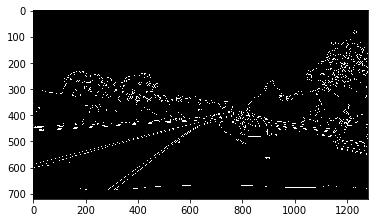

In [8]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

## HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))